# Project 3 - Thermal inspection (classifying the defects) of photovoltaic modules

## Assignment 2 (preliminary delivery)

**Computer Vision**

Master in Data Science and Engineering - Faculdade de Engenharia da Universidade do Porto


Cátia Teixeira (200808037) |  Miguel Veloso (202202463)



---



## Introduction

The following classes are present in our dataset:



1.  **Cell Module**: a hot spot that appears in a single cell
2.   **Cell-Multi Module**: one of the hot spots in multiple cells
3.   **Cracking**: appeared on the surface of the module in single or multiple long-curve
4.    **Diode module**: activated bypass diode in about 1/3 area of the
module, which looks like a straight line in the IR image
5.   **Diode-Multi module**: activated bypass diode in about 2/3 area of the module
6.   **Hot-Spot module**: hot-spot in a thin film module
7. **Hot-Spot-Multi module**: multiple hot-spot in the thin-film module
8. **Offline module**: s heated entire the module (which looks like the No-anomaly module)
9. **Shadowing module**: blocked by vegetation or manmade structure
10. **Vegetation module**: blocked by vegetation (which is similar to the Shadowing module)
11. **Soiling module**: dirt or dust on the surface of the module (which looks like the Cell or Vegetation modules in the IR image)
12. **No-anomaly module**: Nominal solar module









---



## Methodology

The following steps were not completed at the moment due to resource/time restrictions.

* Several sections of the report need to be completed (Introduction,conclusions, etc)
* Condition D is yet to be implemented.
* Pre-trained ResNET and pre-trained Transformer nedds additinal tunning and further implementation. 

In the following diagram we can see the proposed plan for this project.

<center><img src="flow.drawio.png"/></center>

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
from torchinfo import summary
from torch.optim import Adam, SGD
import cv2
import numpy as np
from PIL import Image
import random, os

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print ("Device is:", device)

Device is: cuda


In [4]:
import utils

In [4]:
import scprep
scprep.io.download.download_and_extract_zip(
   url="https://github.com/RaptorMaps/InfraredSolarModules/raw/master/2020-02-14_InfraredSolarModules.zip",
   destination=".")

In [5]:
metadata_path = "./InfraredSolarModules/module_metadata.json"
images_path = "./InfraredSolarModules/"
solar_dataset = utils.SolarDataset(metadata_path, images_path, random_state=42)

(20000, 2)


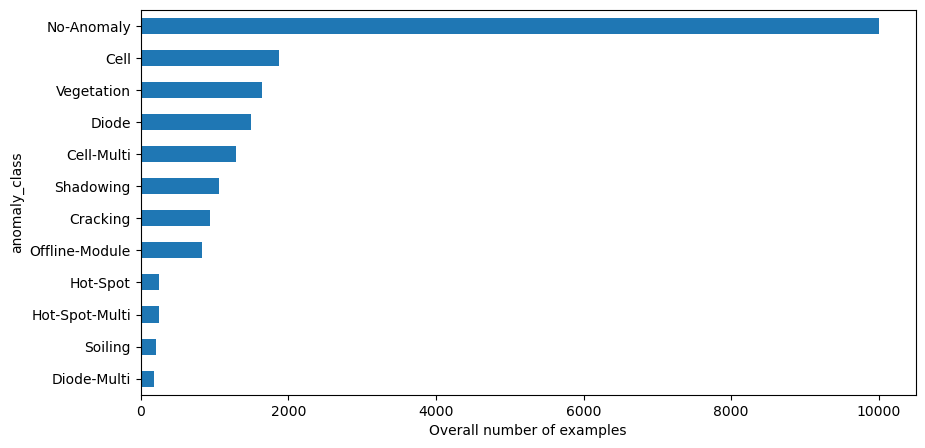

(12801, 2)


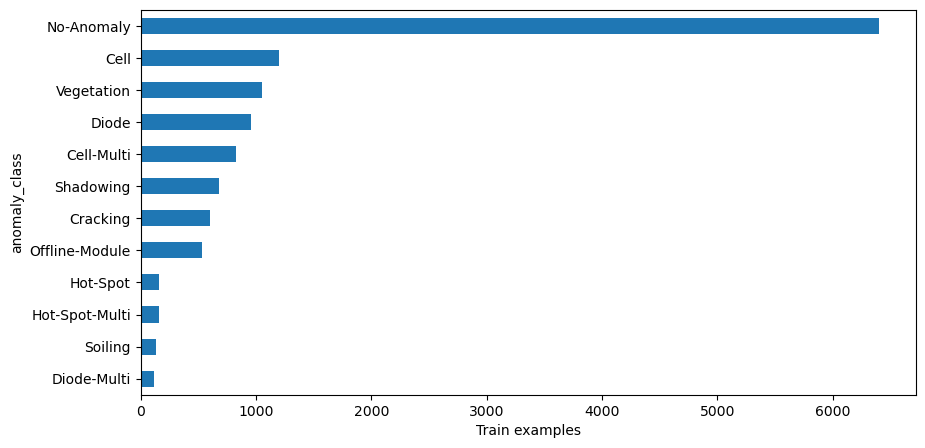

(3199, 2)


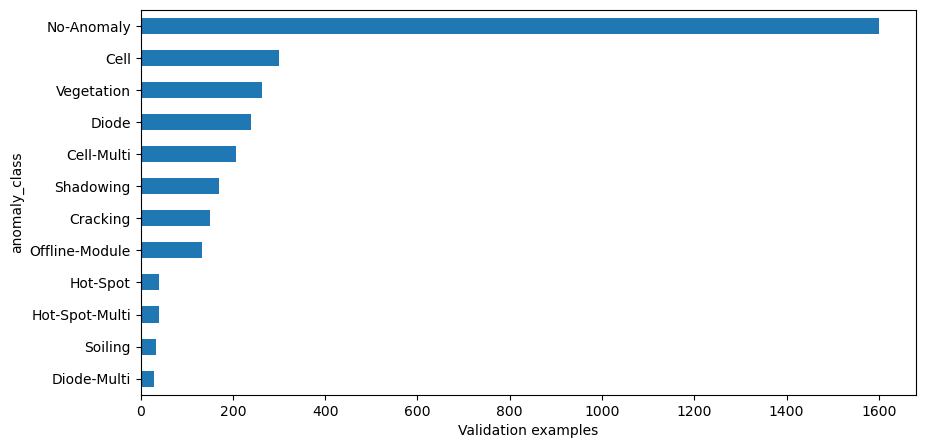

(4000, 2)


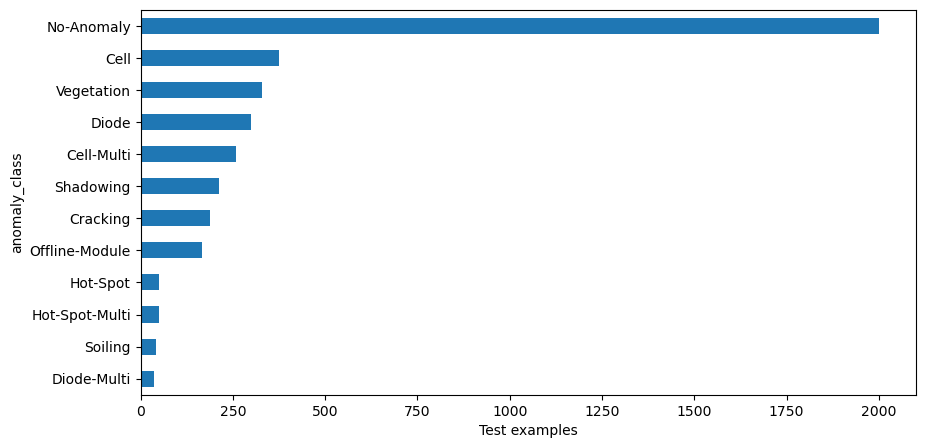

In [6]:
dfs_to_show = [
    [solar_dataset.full_df, "Overall number of examples"],
    [solar_dataset.train_df, "Train examples"],
    [solar_dataset.val_df, "Validation examples"],
    [solar_dataset.test_df, "Test examples"],
]

for (d, t) in dfs_to_show:
    ax = d.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
    ax.set_xlabel(t)
    print(d.shape)
    plt.show()

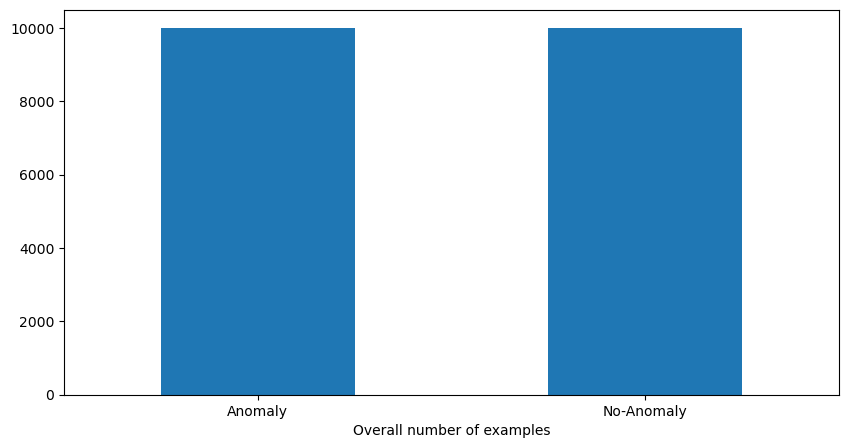

In [7]:
def convert_to_binary(x):
    x = 'Anomaly' if x != 'No-Anomaly' else x
    return x

df_binary = solar_dataset.full_df.copy()
df_binary['anomaly_class'] = solar_dataset.full_df.anomaly_class.apply(convert_to_binary)
ax = df_binary['anomaly_class'].value_counts().plot.bar(figsize=(10,5))
ax.tick_params(labelrotation=0)
ax.set_xlabel('Overall number of examples')
plt.show()

# Basic Pre-Processing

In [8]:
def preprocess_none(image, aug_number=0, label=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image[np.newaxis]
    return [image]

In [9]:
def preprocess_basic(image, aug_number=0, label=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = (image - 127.5) / 127.5
    image = image[np.newaxis]
    return [image]

# Defining Model from Paper

In [159]:
class PaperClassificator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            # BLock 1
            nn.Conv2d(in_dim[0], 80, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(80),
            # Block 2
            nn.Conv2d(80, 160, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(160),
            # Block 3
            nn.Conv2d(160, 320, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(320),
            # Block 4
            nn.Conv2d(320, 640, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(1, 2),
            nn.BatchNorm2d(640),
            # Average Pool
            nn.AvgPool2d(2),
            # Fully connected
            nn.Flatten(),
            nn.Linear(640, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.model(x)

## Running model from paper

In [11]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
paper_model = PaperClassificator(input_dim, output_dim).to(device)
print(summary(paper_model, (1, input_dim[0], input_dim[1], input_dim[2])))
paper_loss = torch.nn.CrossEntropyLoss()
paper_optimizer = Adam(paper_model.parameters(), lr=0.0003)
paper_train_test = utils.TrainTest(
    paper_model,
    paper_loss,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_none,
)

Layer (type:depth-idx)                   Output Shape              Param #
PaperClassificator                       [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 80, 40, 24]           800
│    └─ReLU: 2-2                         [1, 80, 40, 24]           --
│    └─MaxPool2d: 2-3                    [1, 80, 20, 12]           --
│    └─BatchNorm2d: 2-4                  [1, 80, 20, 12]           160
│    └─Conv2d: 2-5                       [1, 160, 20, 12]          115,360
│    └─ReLU: 2-6                         [1, 160, 20, 12]          --
│    └─MaxPool2d: 2-7                    [1, 160, 10, 6]           --
│    └─BatchNorm2d: 2-8                  [1, 160, 10, 6]           320
│    └─Conv2d: 2-9                       [1, 320, 10, 6]           461,120
│    └─ReLU: 2-10                        [1, 320, 10, 6]           --
│    └─MaxPool2d: 2-11                   [1, 320, 5, 3]            --
│ 

In [12]:
# Train Model
paper_best_loss, paper_best_accuracy, paper_best_epoch = paper_train_test.train(paper_optimizer, 166, "paper_model.pth")

Loss = 1.986934258824303   Accuracy= 0.6307043650793651
Best Epoch # 0  Validation Loss= 1.986934258824303  Validation Accu= 0.6307043650793651
Loss = 1.9564952698964921   Accuracy= 0.6604662698412699
Best Epoch # 1  Validation Loss= 1.9564952698964921  Validation Accu= 0.6604662698412699
Loss = 1.965593345581539   Accuracy= 0.6520337301587301
Loss = 1.93331912207225   Accuracy= 0.6875
Best Epoch # 3  Validation Loss= 1.93331912207225  Validation Accu= 0.6875
Loss = 1.9350809710366386   Accuracy= 0.6832837301587301
Loss = 1.916107349925571   Accuracy= 0.7036210317460317
Best Epoch # 5  Validation Loss= 1.916107349925571  Validation Accu= 0.7036210317460317
Loss = 1.9148089015294636   Accuracy= 0.7058531746031746
Best Epoch # 6  Validation Loss= 1.9148089015294636  Validation Accu= 0.7058531746031746
Loss = 1.9129803615903098   Accuracy= 0.7063492063492064
Best Epoch # 7  Validation Loss= 1.9129803615903098  Validation Accu= 0.7063492063492064
Loss = 1.8977604044808283   Accuracy= 0.719

KeyboardInterrupt: 

Loss = 1.826314339562068   Accuracy= 0.7919146825396826


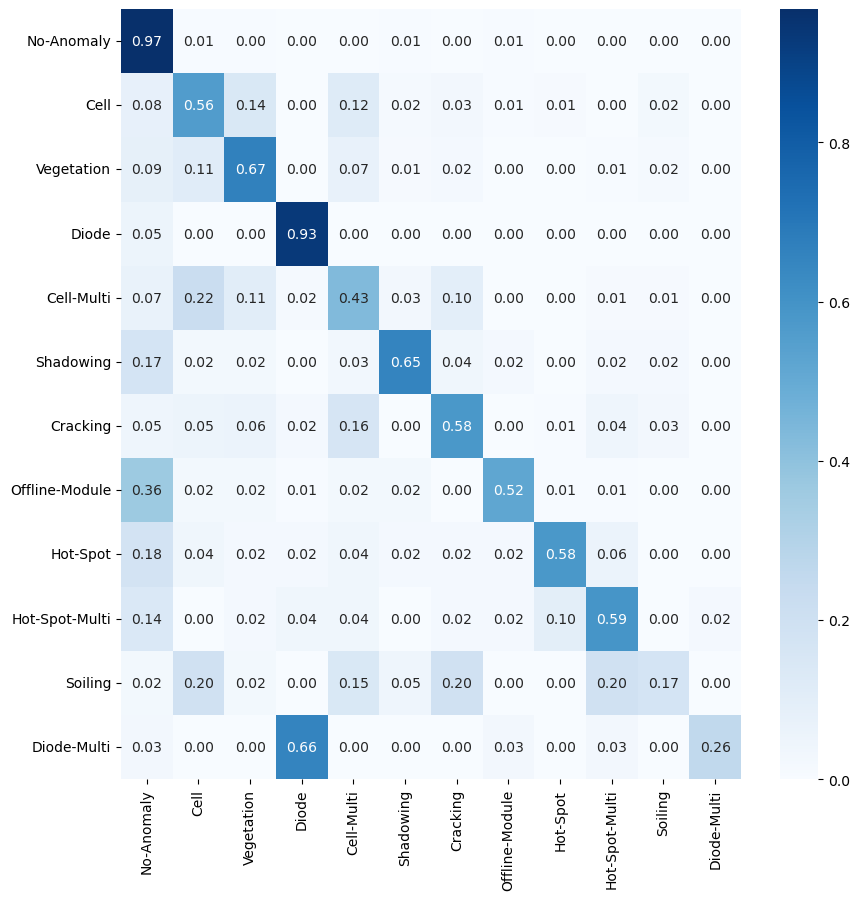

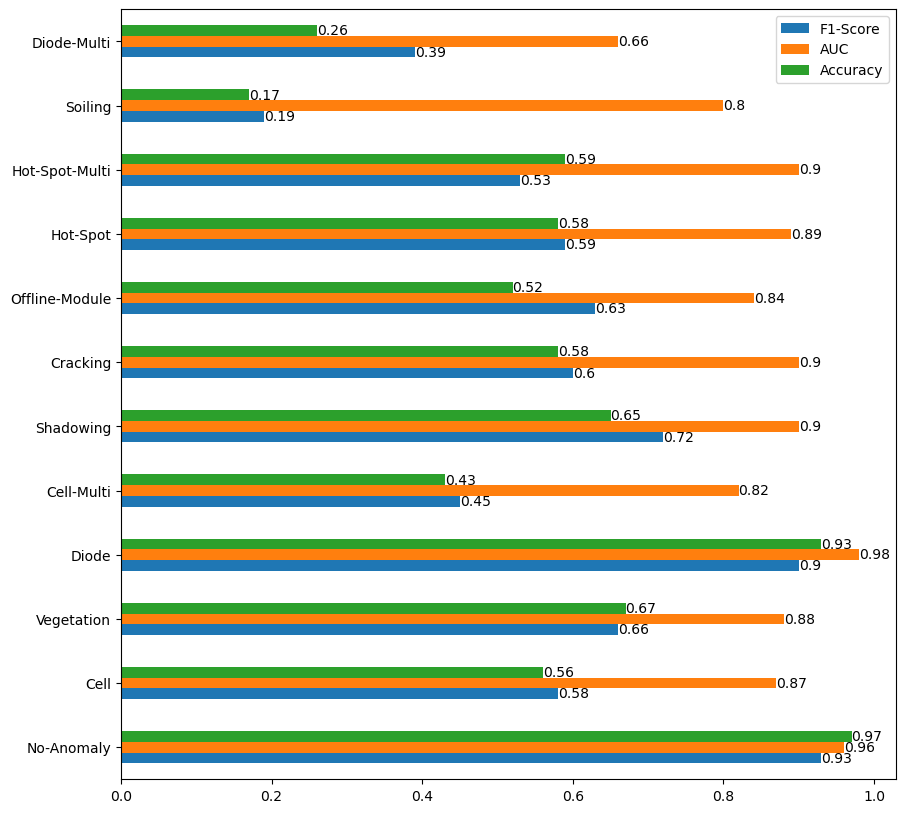

In [13]:
paper_train_test.test()
paper_train_test.plot_confusion_matrix()
paper_train_test.plot_class_metrics()

---

# Defining our CNN model

In [32]:
class OurClassificator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_dim[0], 60, 3, 1, 1),
            nn.BatchNorm2d(60),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.MaxPool2d(2, 2),
            # Input is Zx20x12
            nn.Conv2d(60, 120, 3, 1, 1),
            #nn.BatchNorm2d(120),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.MaxPool2d(2, 2),
            # Input is Zx10x6
            nn.Conv2d(120, 240, 3, 1, 1),
            #nn.BatchNorm2d(240),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.MaxPool2d(2, 2),
            # Input is Zx5x3
            nn.Conv2d(240, 480, (5, 3), 1, 0),
            #nn.BatchNorm2d(480),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Flatten(),
            nn.Linear(480, 960),
            nn.Sigmoid(),
            nn.Linear(960, out_dim),
        )

    def forward(self, x):
        return self.model(x)

In [40]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss = nn.CrossEntropyLoss().to(device)
our_optimizer = Adam(our_model.parameters(), lr=0.00003)
our_train_test = utils.TrainTest(
    our_model,
    our_loss,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_basic,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 60, 40, 24]           600
│    └─BatchNorm2d: 2-2                  [1, 60, 40, 24]           120
│    └─ReLU: 2-3                         [1, 60, 40, 24]           --
│    └─Dropout: 2-4                      [1, 60, 40, 24]           --
│    └─MaxPool2d: 2-5                    [1, 60, 20, 12]           --
│    └─Conv2d: 2-6                       [1, 120, 20, 12]          64,920
│    └─ReLU: 2-7                         [1, 120, 20, 12]          --
│    └─Dropout: 2-8                      [1, 120, 20, 12]          --
│    └─MaxPool2d: 2-9                    [1, 120, 10, 6]           --
│    └─Conv2d: 2-10                      [1, 240, 10, 6]           259,440
│    └─ReLU: 2-11                        [1, 240, 10, 6]           --
│   

Loss = 1.7026259123332916   Accuracy= 0.5064484126984127
Best Epoch # 0  Validation Loss= 1.7026259123332916  Validation Accu= 0.5064484126984127
Loss = 1.5772061925085763   Accuracy= 0.5300099206349206
Best Epoch # 1  Validation Loss= 1.5772061925085763  Validation Accu= 0.5300099206349206
Loss = 1.4857207413703677   Accuracy= 0.5476190476190477
Best Epoch # 2  Validation Loss= 1.4857207413703677  Validation Accu= 0.5476190476190477
Loss = 1.417768208753495   Accuracy= 0.5582837301587301
Best Epoch # 3  Validation Loss= 1.417768208753495  Validation Accu= 0.5582837301587301
Loss = 1.3740618839150383   Accuracy= 0.5704365079365079
Best Epoch # 4  Validation Loss= 1.3740618839150383  Validation Accu= 0.5704365079365079
Loss = 1.3162733032589866   Accuracy= 0.5974702380952381
Best Epoch # 5  Validation Loss= 1.3162733032589866  Validation Accu= 0.5974702380952381
Loss = 1.2657514276012543   Accuracy= 0.6187996031746031
Best Epoch # 6  Validation Loss= 1.2657514276012543  Validation Accu=

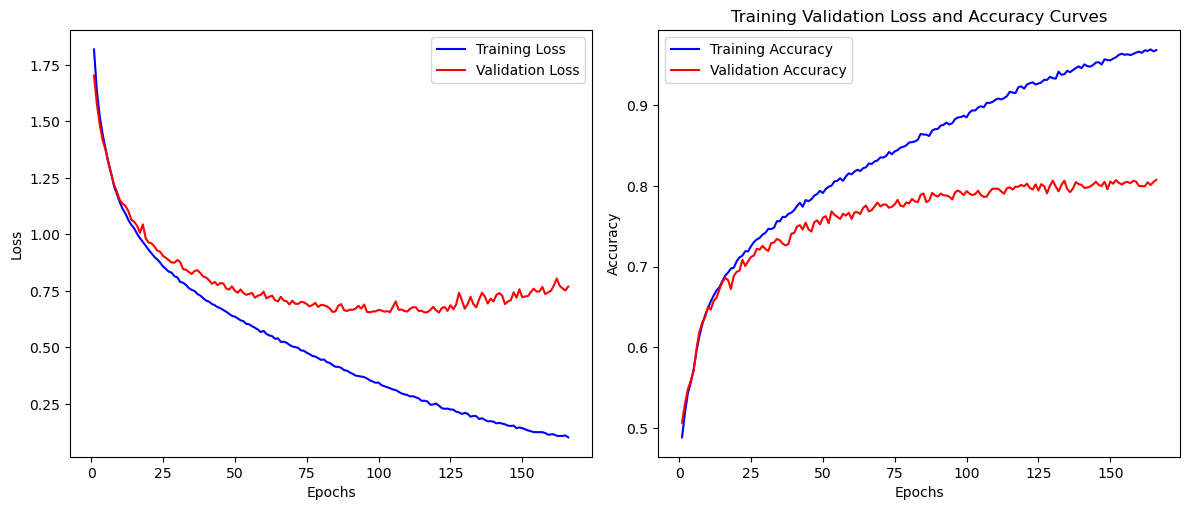

In [41]:
# Train Model
our_best_loss, our_best_accuracy, our_best_epoch = our_train_test.train(our_optimizer, 166, "our_model.pth")

Loss = 0.7696327113265556   Accuracy= 0.8072916666666666


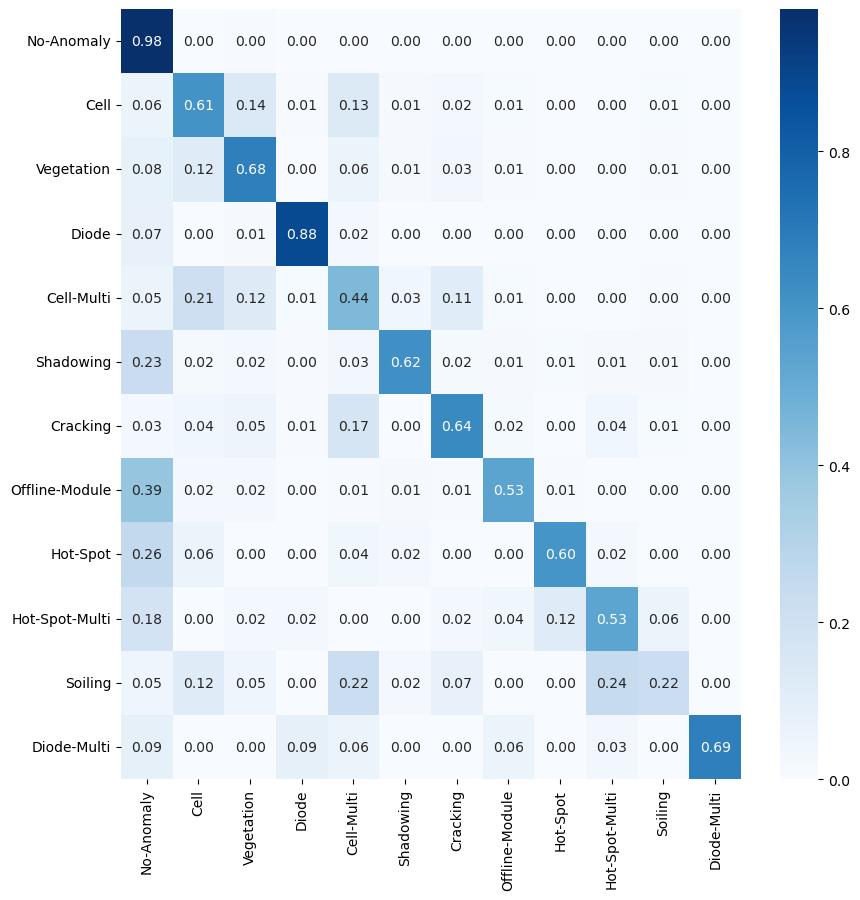

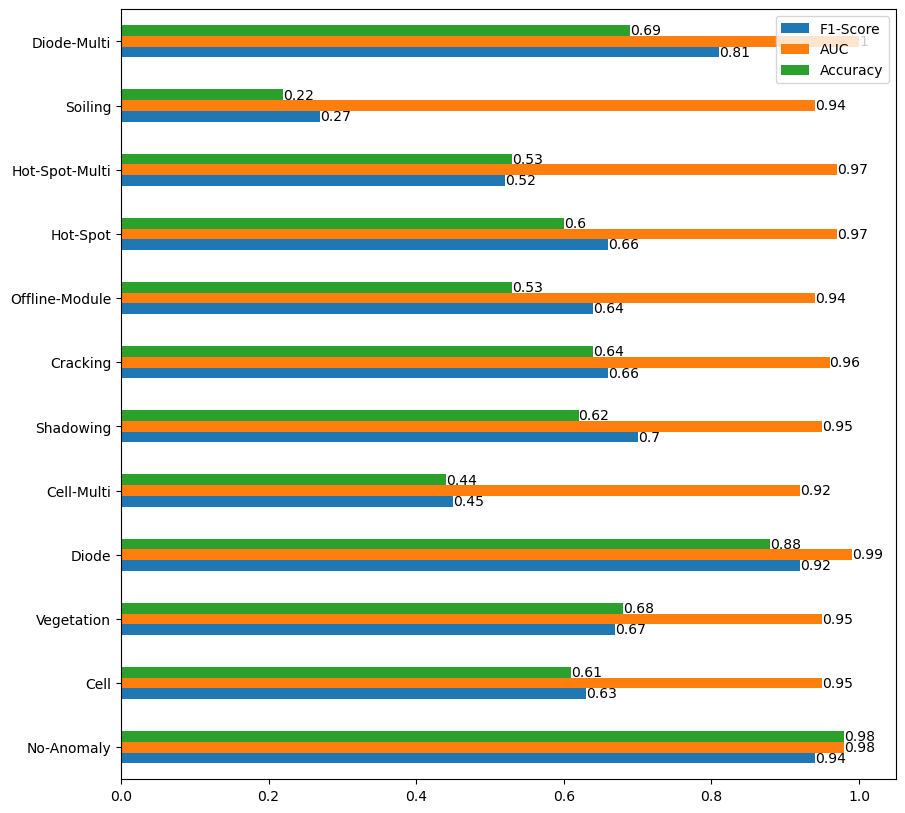

In [42]:
our_train_test.test()
our_train_test.plot_confusion_matrix()
our_train_test.plot_class_metrics()

---

# Adding Class Sensitive Learning (condition B)

In [29]:
total_imgs = len(solar_dataset.train_df)
class_weights = np.zeros(solar_dataset.num_classes)
for k, v in dict(solar_dataset.train_df.anomaly_class.value_counts()).items():
    class_weights[solar_dataset.classes_list.index(k)] = v
class_weights = torch.tensor([total_imgs/(class_imgs*solar_dataset.num_classes) for class_imgs in class_weights]).to(device)
print(class_weights)
print(solar_dataset.classes_list)

tensor([0.1667, 0.8875, 1.0169, 1.1124, 1.2946, 1.5780, 1.7720, 2.0127, 6.7091,
        6.7516, 8.2058, 9.5246], device='cuda:0', dtype=torch.float64)
['No-Anomaly', 'Cell', 'Vegetation', 'Diode', 'Cell-Multi', 'Shadowing', 'Cracking', 'Offline-Module', 'Hot-Spot', 'Hot-Spot-Multi', 'Soiling', 'Diode-Multi']


In [39]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model_w = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model_w, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss_w = nn.BCELoss(weight=class_weights)
our_optimizer_w = Adam(our_model_w.parameters(), lr=0.0001)
our_train_test_w = utils.TrainTest(
    our_model_w,
    our_loss_w,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_basic,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 32, 20, 12]           544
│    └─BatchNorm2d: 2-2                  [1, 32, 20, 12]           64
│    └─LeakyReLU: 2-3                    [1, 32, 20, 12]           --
│    └─Dropout: 2-4                      [1, 32, 20, 12]           --
│    └─Conv2d: 2-5                       [1, 64, 10, 6]            32,832
│    └─BatchNorm2d: 2-6                  [1, 64, 10, 6]            128
│    └─LeakyReLU: 2-7                    [1, 64, 10, 6]            --
│    └─Dropout: 2-8                      [1, 64, 10, 6]            --
│    └─Conv2d: 2-9                       [1, 128, 5, 3]            131,200
│    └─BatchNorm2d: 2-10                 [1, 128, 5, 3]            256
│    └─LeakyReLU: 2-11                   [1, 128, 5, 3]            --
│  

Best Epoch # 0  Validation Loss= 0.3121906518936157  Validation Accu= 0.5010940919037199
Best Epoch # 1  Validation Loss= 0.2704817056655884  Validation Accu= 0.5801813066583307
Best Epoch # 2  Validation Loss= 0.2575124204158783  Validation Accu= 0.6367614879649891
Best Epoch # 3  Validation Loss= 0.24496358633041382  Validation Accu= 0.6398874648327603
Best Epoch # 4  Validation Loss= 0.23712188005447388  Validation Accu= 0.644576430134417
Best Epoch # 5  Validation Loss= 0.22380539774894714  Validation Accu= 0.6633322913410441
Best Epoch # 6  Validation Loss= 0.219967320561409  Validation Accu= 0.668646452016255
Best Epoch # 7  Validation Loss= 0.21328067779541016  Validation Accu= 0.6814629571741169
Best Epoch # 8  Validation Loss= 0.2155739814043045  Validation Accu= 0.6861519224757737
Best Epoch # 9  Validation Loss= 0.20555256307125092  Validation Accu= 0.7020944045014067
Best Epoch # 11  Validation Loss= 0.20624962449073792  Validation Accu= 0.7086589559237262
Best Epoch # 13  

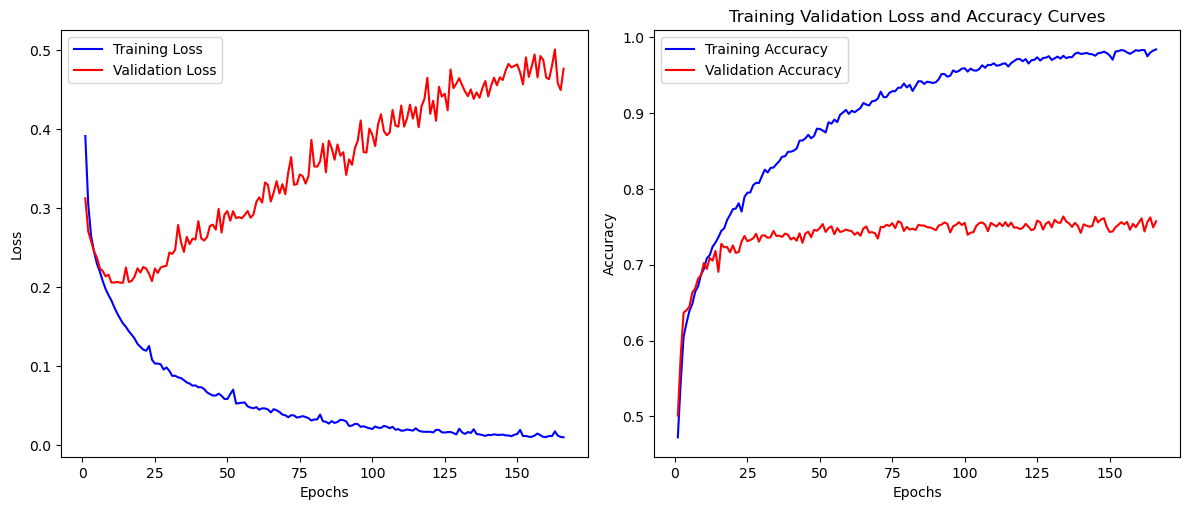

In [40]:
# Train Model
our_best_w_loss, our_best_w_accuracy, our_best_w_epoch = our_train_test_w.train(our_optimizer_w, 166, "our_model_w.pth")

Loss = 0.4307741317679174   Accuracy= 0.7755


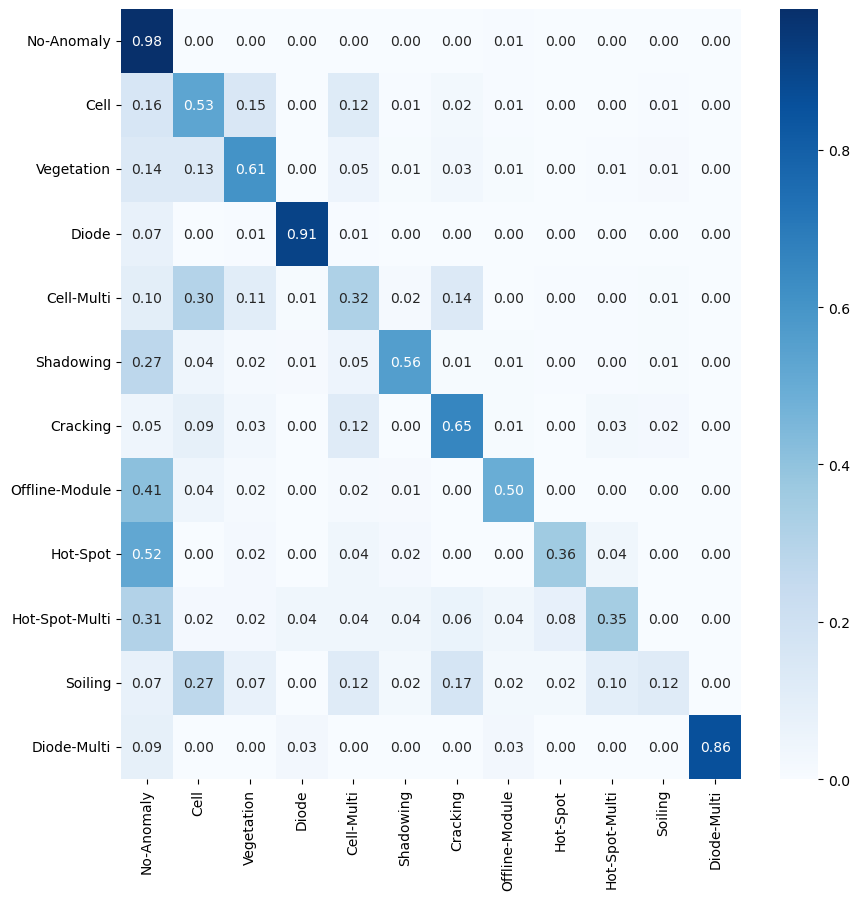

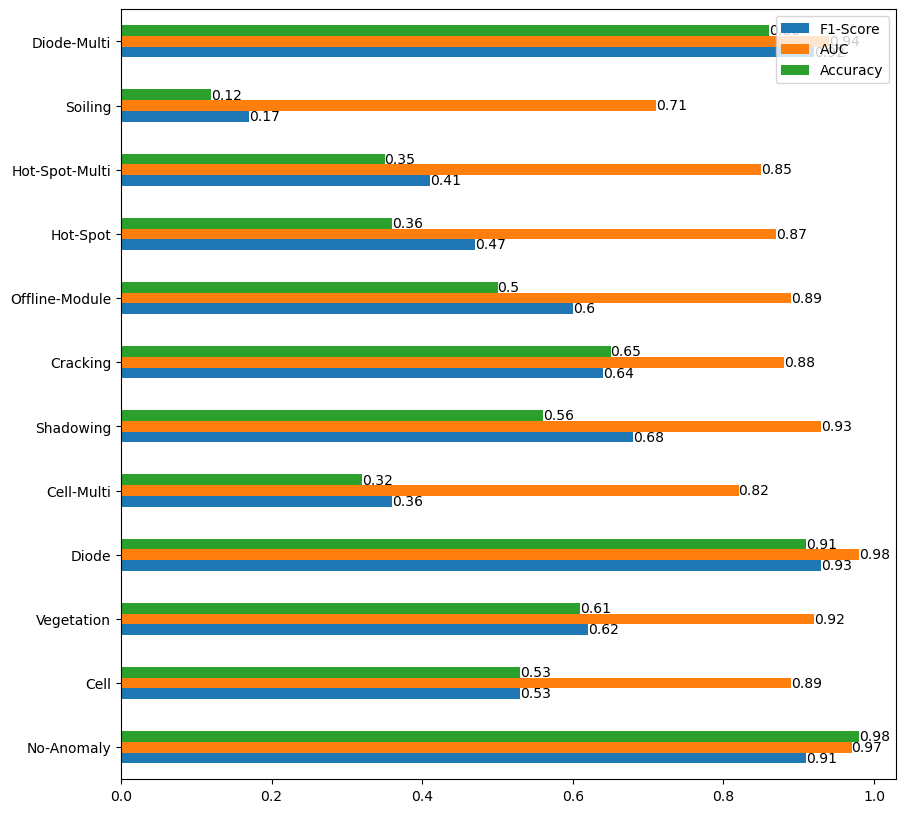

In [41]:
our_train_test_w.test()
our_train_test_w.plot_confusion_matrix()
our_train_test_w.plot_class_metrics()

---

# Adding Data Augmentation (condition C)

### Traditional data augmentation techniques

We first start with our baseline model, without using any data augmentation, however and since our dataset is relatively small, speacially if we consider that half of the dataset is only for one class (10000 samples for Non Anomaly Class), we decided to do some experiments with data augmentation.
Applying data augmentation usually provide better results since it increases the training set size by generating additional training samples by applying transformations such as rotation, flipping, scaling, and cropping to the original images. This increases the diversity of the dataset, which can be particularly beneficial when working with limited labeled data.

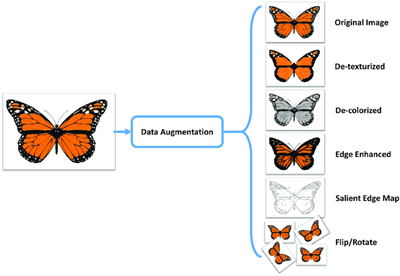

Below a few types of transformations were defined, some had more success than others (increasing or decreasing the model accuracy).
<br><br>
**RandomRotation**(degrees) : Rotate the image by angle.   
degrees : Range of degrees to select from. If degrees is a number instead of sequence like (min, max), the range of degrees will be (-degrees, +degrees).

**RandomHorizontalFlip**(p) : Horizontally flip the given PIL Image randomly with a given probability p

**RandomVertitalFlip**(p) : Vertitally flip the given PIL Image randomly with a given probability p

**ColorJitter**(brightness=0, contrast=0, saturation=0, hue=0) :
Randomly change the brightness, contrast and saturation of an image.
The parameters describe how much to jitter.



In [9]:
def preprocess_augment(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.21),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5652, 0.5652, 0.5652), std=(0.5, 0.5, 0.5)),
            transforms.Grayscale(),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5652, 0.5652, 0.5652), std=(0.5, 0.5, 0.5)),
            transforms.Grayscale(),
        ])
    ]

    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [43]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model_aug = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model_aug, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss_aug = nn.BCELoss()
our_optimizer_aug = Adam(our_model_aug.parameters(), lr=0.0001)
our_train_test_aug = utils.TrainTest(
    our_model_aug,
    our_loss_aug,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_augment,
    augment=True,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 32, 20, 12]           544
│    └─BatchNorm2d: 2-2                  [1, 32, 20, 12]           64
│    └─LeakyReLU: 2-3                    [1, 32, 20, 12]           --
│    └─Dropout: 2-4                      [1, 32, 20, 12]           --
│    └─Conv2d: 2-5                       [1, 64, 10, 6]            32,832
│    └─BatchNorm2d: 2-6                  [1, 64, 10, 6]            128
│    └─LeakyReLU: 2-7                    [1, 64, 10, 6]            --
│    └─Dropout: 2-8                      [1, 64, 10, 6]            --
│    └─Conv2d: 2-9                       [1, 128, 5, 3]            131,200
│    └─BatchNorm2d: 2-10                 [1, 128, 5, 3]            256
│    └─LeakyReLU: 2-11                   [1, 128, 5, 3]            --
│  

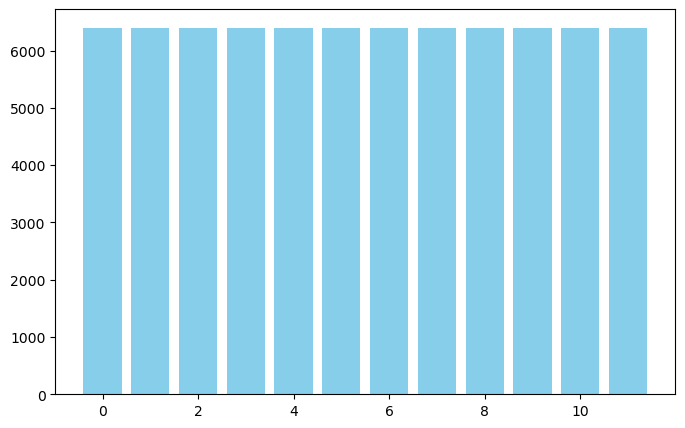

6400 6400


In [44]:
labels = []
for _, target in our_train_test_aug.train_dataloader:
    labels.extend(target.numpy())

counts = {}
for l in labels:
    if l not in counts:
        counts[l] = 0
    counts[l] += 1

class_l = list(counts.keys())
counts = list(counts.values())

plt.figure(figsize=(8,5))
plt.bar(class_l, counts, color="skyblue")
plt.show()

print(np.max(counts), np.min(counts))

Best Epoch # 0  Validation Loss= 0.19823326170444489  Validation Accu= 0.49109096592685214
Best Epoch # 1  Validation Loss= 0.18755243718624115  Validation Accu= 0.5110972178805877
Best Epoch # 2  Validation Loss= 0.17010831832885742  Validation Accu= 0.5667396061269147
Best Epoch # 3  Validation Loss= 0.1618265062570572  Validation Accu= 0.6201938105658018
Best Epoch # 4  Validation Loss= 0.1564638614654541  Validation Accu= 0.6523913723038449
Best Epoch # 7  Validation Loss= 0.15675713121891022  Validation Accu= 0.6770865895592373
Best Epoch # 9  Validation Loss= 0.16502222418785095  Validation Accu= 0.6792747733666771
Best Epoch # 10  Validation Loss= 0.16858264803886414  Validation Accu= 0.7020944045014067
Best Epoch # 16  Validation Loss= 0.1777888983488083  Validation Accu= 0.7092841512972804
Best Epoch # 19  Validation Loss= 0.18618768453598022  Validation Accu= 0.7195998749609253
Best Epoch # 26  Validation Loss= 0.19239984452724457  Validation Accu= 0.7230384495154736
Best Epo

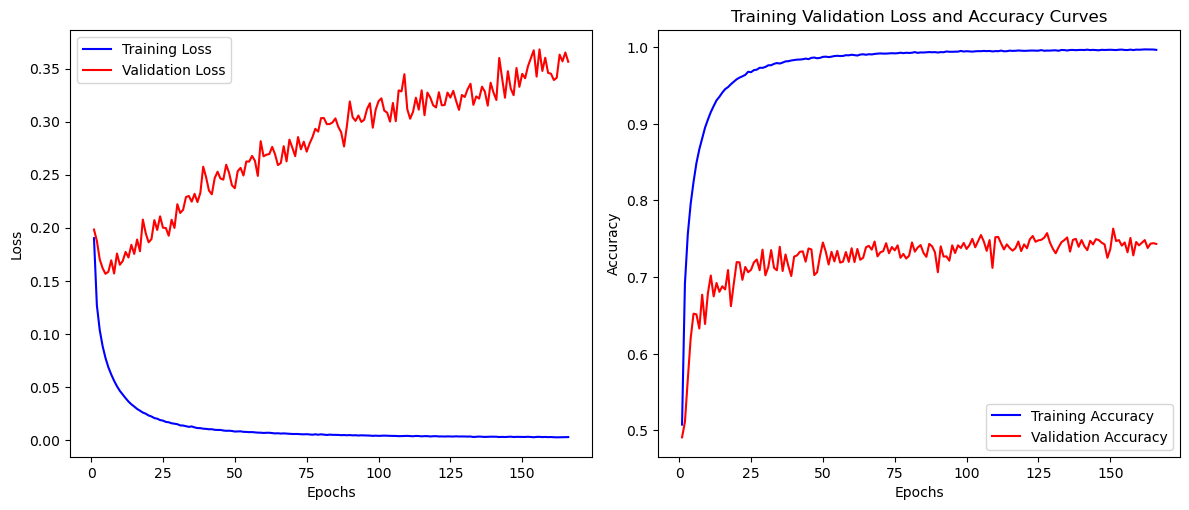

In [45]:
# Train Model
our_best_aug_loss, our_best_aug_accuracy, our_best_aug_epoch = our_train_test_aug.train(our_optimizer_aug, 166, "our_model_aug.pth")

Loss = 0.27028214931488037   Accuracy= 0.7985


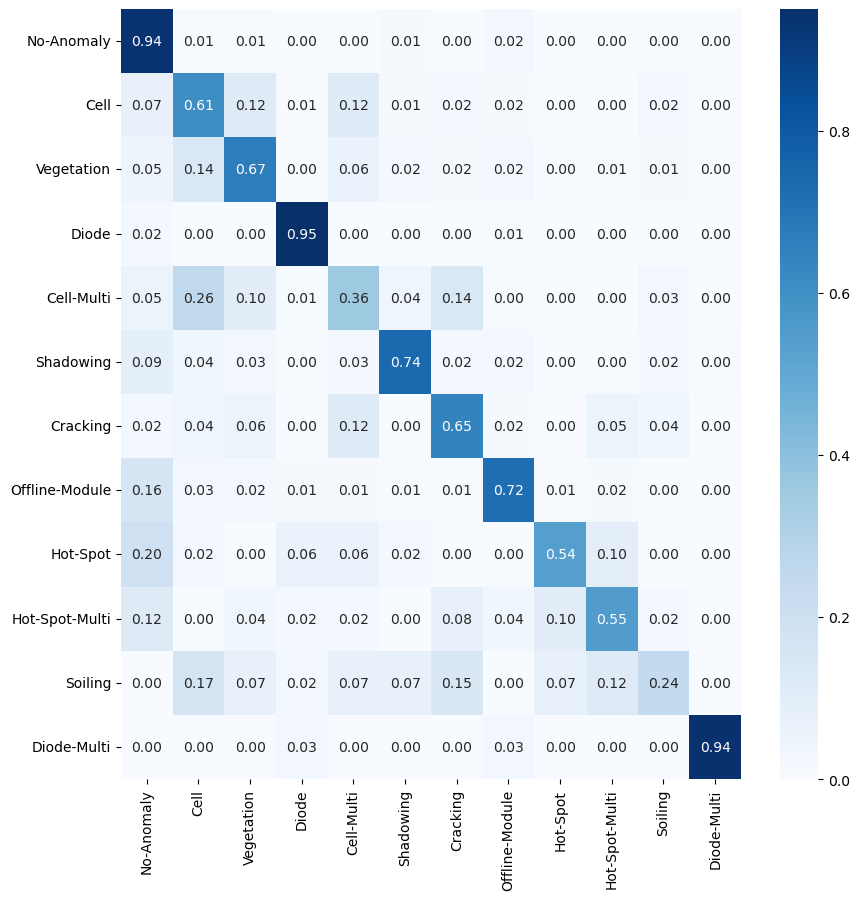

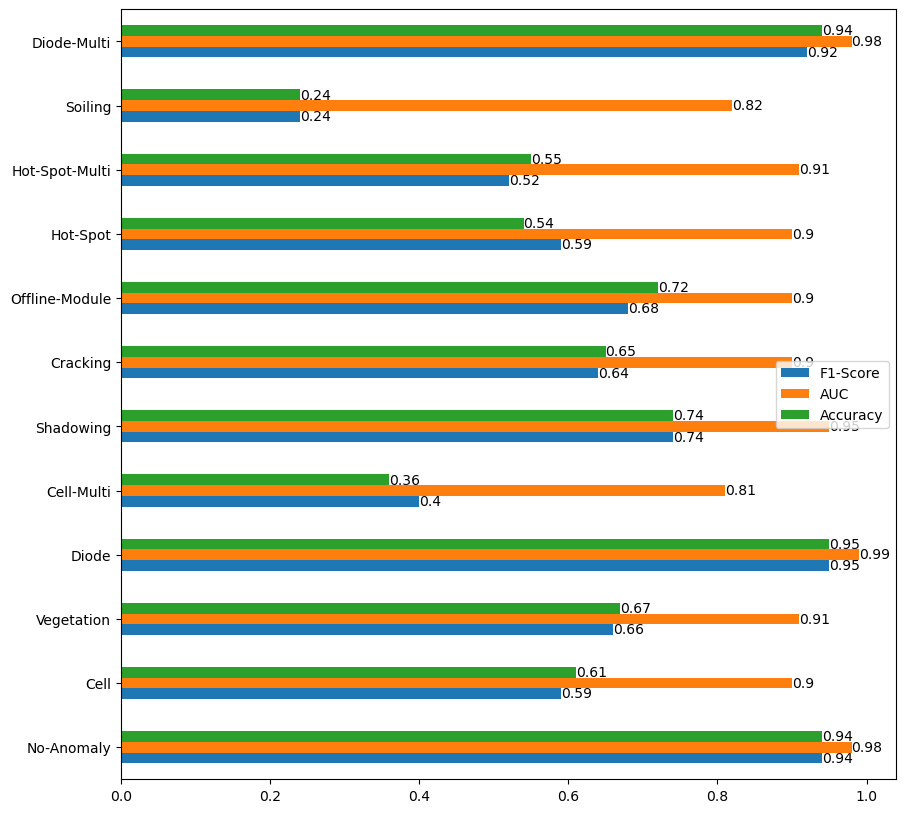

In [36]:
our_train_test_aug.test()
our_train_test_aug.plot_confusion_matrix()
our_train_test_aug.plot_class_metrics()

---

# Data Augmentation (Condition D)

Using GAN's for Data Augmentation

TBD

In [24]:
def preprocess_gan(image, aug_number=0, label=None):
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = (image - 127.5) / 127.5
    image = image[np.newaxis]
    return [image]

In [177]:
class GAugmented(nn.Module):
    def __init__(self, img_shape, solar_dataset, latent_dim=128, features_gen=32, features_disc=32):
        super().__init__()
        self.img_size = img_shape[0] * img_shape[1] * img_shape[2]
        self.features_gen = features_gen
        self.features_disc = features_disc
        self.generator = self.Generator(latent_dim, img_shape, img_shape[0], features_gen, solar_dataset.num_classes).to(device)
        #self.generator.weight_init(mean=0.0, std=0.02)
        self.discriminator = self.Discriminator(img_shape[0], features_disc, solar_dataset.num_classes).to(device)
        #self.discriminator.weight_init(mean=0.0, std=0.02)
        self.lr_gen = 0.0002
        self.lr_disc = 0.0002
        self.batch_size = 128
        # self.epochs = 500
        self.latent_dim = latent_dim
        self.img_shape = img_shape
        self.solar_dataset = solar_dataset

        print(summary(self.generator,
                [(1, latent_dim, 1, 1), (1, solar_dataset.num_classes, 1, 1)]))
        print(summary(self.discriminator,
                [(1, img_shape[0], img_shape[1], img_shape[2]),
                 (1, solar_dataset.num_classes, img_shape[1], img_shape[2])]))

        # Optimizers and loss function
        beta1 = 0.5
        self.optimizer_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr_gen, betas=(beta1, 0.999))
        self.optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr_disc, betas=(beta1, 0.999))
        self.adversarial_loss = nn.BCELoss()
        self.conditioning_loss = nn.CrossEntropyLoss()

    def fit(self, dataloader, epochs=500):
        fit_total_loss_gen = []
        fit_total_loss_disc = []

        for epoch in range(epochs):
            loss_gen = 0
            loss_disc = 0
            for i, (real_imgs, real_labels) in enumerate(dataloader):
                real_imgs = real_imgs.to(device)
                real_labels = real_labels.to(device)
                batch_size = real_imgs.size(0)

                # Adversarial ground truths
                valid = torch.autograd.Variable(torch.ones(batch_size, 1)).to(device)
                #valid = torch.autograd.Variable(torch.full((batch_size, 1), 0.9)).to(device)
                fake = torch.autograd.Variable(torch.zeros(batch_size, 1)).to(device)

                # Generate fake data
                z = torch.autograd.Variable(torch.randn(batch_size, self.latent_dim, 1, 1)).to(device)
                fake_labels = torch.autograd.Variable(torch.FloatTensor(np.random.randint(0, self.solar_dataset.num_classes, batch_size))).to(device)

                # One hot encoded labels
                fill_d = torch.zeros([self.solar_dataset.num_classes, self.solar_dataset.num_classes, real_imgs.size(2), real_imgs.size(3)]).to(device)
                fill_g = torch.zeros([self.solar_dataset.num_classes, self.solar_dataset.num_classes, 1, 1]).to(device)
                for i in range(self.solar_dataset.num_classes):
                    fill_d[i, i, :, :] = 1
                    fill_g[i, i, :, :] = 1

                # Labels fake and real
                label_real_disc = fill_d[real_labels.to(torch.int64)]
                label_fake_disc = fill_d[fake_labels.to(torch.int64)]
                label_fake_gen = fill_g[fake_labels.to(torch.int64)]

                # Generate samples
                gen_imgs = self.generator(z, label_fake_gen)

                # Train discriminator
                self.optimizer_d.zero_grad()
                output_real = self.discriminator(real_imgs, label_real_disc)
                loss_real = self.adversarial_loss(output_real, valid)
                output_fake = self.discriminator(gen_imgs.detach(), label_fake_disc)
                loss_fake = self.adversarial_loss(output_fake, fake)
                #loss_cond_real = self.conditioning_loss(output_real, valid)
                #loss_cond_fake = self.conditioning_loss(output_fake, fake)
                #total_loss_disc = 0.50 * (loss_real + loss_fake)# + loss_cond_real + loss_cond_fake)
                total_loss_disc = 0.50 * (loss_real + loss_fake)
                total_loss_disc.backward()
                self.optimizer_d.step()

                # Train generator
                self.optimizer_g.zero_grad()
                output_fake_generator = self.discriminator(gen_imgs, label_fake_disc)
                loss_generator = self.adversarial_loss(output_fake_generator, valid)
                #loss_cond_generator = self.conditioning_loss(output_fake_generator, valid)
                total_loss_generator = loss_generator# + loss_cond_generator
                total_loss_generator.backward()
                self.optimizer_g.step()

                loss_gen += total_loss_generator.item()
                loss_disc += total_loss_disc.item()

            loss_gen = loss_gen / len(dataloader)
            loss_disc = loss_disc / len(dataloader)
            fit_total_loss_gen.append(loss_gen)
            fit_total_loss_disc.append(loss_disc)

            print(f"[Epoch {epoch}/{epochs}]"
                  f" [D loss: {loss_disc}] [G loss: {loss_gen}]")

            if epoch % 10 == 0:
                torch.save(self.state_dict(), "gan_model_temporary.pth")
                plt.figure(figsize=(15,15))
                for j in range(self.solar_dataset.num_classes):
                    image = self.augment(1, j)[0].cpu().numpy()
                    plt.subplot(6, 6, j+1)
                    plt.imshow((image.transpose(1, 2, 0) + 1.0) / 2.0)
                    plt.title(self.solar_dataset.classes_list[j])
                    plt.axis('off')
                plt.show()

        return fit_total_loss_gen, fit_total_loss_disc


    def augment(self, num, cat):
        def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
                yield iterable[ndx:min(ndx + n, l)]

        with torch.no_grad():
            self.eval()
            gen_imgs = []
            for x_num in batch(range(num), n=100):
                n = len(x_num)
                z = torch.randn(n, self.latent_dim, 1, 1).to(device)
                c = torch.tensor(cat).repeat(n)
                #one_hot = nn.functional.one_hot(c.to(torch.int64), num_classes=num_classes)
                #l = one_hot.to(torch.float32)
                #l_g = l.view(n, num_classes, 1, 1).to(device)
                fill_g = torch.zeros([self.solar_dataset.num_classes, self.solar_dataset.num_classes, 1, 1]).to(device)
                for i in range(self.solar_dataset.num_classes):
                    fill_g[i, i, :, :] = 1
                l_g = fill_g[c.to(torch.int64)]
                gen = self.generator(z, l_g)
                for g in gen:
                    gen_imgs.append(g.view(self.img_shape[0], self.img_shape[1], self.img_shape[2]))
            return gen_imgs

    class Generator(nn.Module):
        def __init__(self, in_dim, out_shape, out_size, features, cats):
            super().__init__()
            self.in_dim = in_dim
            self.out_size = out_size
            self.out_shape = out_shape
            self.ngf = features
            self.cats = cats
            self.model_x = nn.Sequential(
                nn.ConvTranspose2d(self.in_dim, self.ngf*4, (5, 3), 1, 0, padding_mode="zeros"),
                #nn.BatchNorm2d(self.ngf*8),
                nn.LeakyReLU(0.2),
            )
            self.model_y = nn.Sequential(
                nn.ConvTranspose2d(self.cats, self.ngf*4, (5, 3), 1, 0, padding_mode="zeros"),
                #nn.BatchNorm2d(self.ngf*8),
                nn.LeakyReLU(0.2),
            )
            self.model_f = nn.Sequential(
                # Input is Zx5x3
                nn.ConvTranspose2d(self.ngf*8, self.ngf*4, 4, 2, 1, padding_mode="zeros"),
                #nn.BatchNorm2d(self.ngf*4),
                nn.LeakyReLU(0.2),
                # Input is Zx10x6
                nn.ConvTranspose2d(self.ngf*4, self.ngf*2, 4, 2, 1, padding_mode="zeros"),
                #nn.BatchNorm2d(self.ngf*2),
                nn.LeakyReLU(0.2),
                # Input is Zx20x12
                nn.ConvTranspose2d(self.ngf*2, self.out_size, 4, 2, 1, padding_mode="zeros"),
                #nn.BatchNorm2d(self.ngf),
                ##nn.LeakyReLU(0.2),
                # Input is Zx40x24
                ##nn.ConvTranspose2d(self.ngf, self.out_size, 3, 1, 1, padding_mode="zeros"),
                #nn.Dropout(0.50),
                nn.Tanh(),
                # Output is Cx40x24
            )

        def weight_init(self, mean, std):
            for m in self._modules:
                self.normal_init(self._modules[m], mean, std)

        def normal_init(self, m, mean, std):
            if isinstance(m, nn.Sequential):
                for l in m:
                    if isinstance(l, nn.ConvTranspose2d) or isinstance(l, nn.Conv2d):
                        l.weight.data.normal_(mean, std)
                        l.bias.data.zero_()
                        print(l)

        def forward(self, z, cat):
            #x = self.model_x(self.lx(z.view(z.size(0), -1)).view(-1, self.ngf**2, 1, 1))
            #y = self.model_y(self.ly(cat.view(cat.size(0), -1)).view(-1, self.ngf**2, 1, 1))
            x = self.model_x(z)
            y = self.model_y(cat)
            img = self.model_f(torch.cat([x, y], 1))
            return img.view(-1, self.out_shape[0], self.out_shape[1], self.out_shape[2])

    class Discriminator(nn.Module):
        def __init__(self, in_dim, features, cats):
            super().__init__()
            self.in_dim = in_dim
            self.ndf = features
            self.cats = cats
            self.model_x = nn.Sequential(
                nn.Conv2d(self.in_dim, self.ndf // 2, 4, 2, "valid"),
                #nn.BatchNorm2d(self.ndf),
                nn.LeakyReLU(0.2),
            )
            self.model_y = nn.Sequential(
                nn.Conv2d(self.cats, self.ndf // 2, 4, 2, "valid"),
                #nn.BatchNorm2d(self.ndf),
                nn.LeakyReLU(0.2),
            )
            self.model_f = nn.Sequential(
                # Input is Cx40x24
                nn.Conv2d(self.ndf, self.ndf*2, 4, 2, "valid"),
                #nn.BatchNorm2d(self.ndf*2),
                nn.LeakyReLU(0.2),
                # Input is Zx20x12
                nn.Conv2d(self.ndf*2, self.ndf*4, 4, 2, "valid"),
                #nn.BatchNorm2d(self.ndf*4),
                nn.LeakyReLU(0.2),
                # Input is Zx10x6
                ##nn.Conv2d(self.ndf*4, self.ndf*8, 3, 1, "valid"),
                #nn.BatchNorm2d(self.ndf*8),
                ##nn.LeakyReLU(0.2),
                # Input is Zx5x3
                nn.Conv2d(self.ndf*4, 1, (5, 3), 1, 1),
                nn.Flatten(),
                #nn.Linear(self.ndf*16*5*3, 512),
                #nn.ReLU(),
                #nn.Linear(512, 256),
                #nn.ReLU(),
                #nn.Linear(256, 1),
                #nn.Dropout(0.50),
                nn.Sigmoid(),
            )

        def weight_init(self, mean, std):
            for m in self._modules:
                self.normal_init(self._modules[m], mean, std)

        def normal_init(self, m, mean, std):
            if isinstance(m, nn.Sequential):
                for l in m:
                    if isinstance(l, nn.ConvTranspose2d) or isinstance(l, nn.Conv2d):
                        l.weight.data.normal_(mean, std)
                        l.bias.data.zero_()
                        print(l)

        def forward(self, x, cat):
            x = self.model_x(x)
            y = self.model_y(cat)
            out = self.model_f(torch.cat([x, y], 1))
            return out.view(out.size(0), -1)

In [178]:
input_dim = (1, 40, 24)
g_model = GAugmented(input_dim, solar_dataset).to(device)
solar_dataset_gan = utils.SolarDataset(metadata_path, images_path, random_state=42, gan_df=True)
g_train_test = utils.TrainTest(
    g_model,
    None,
    g_model.batch_size,
    solar_dataset_gan,
    solar_dataset_gan.train_df_gan,
    device,
    pre_process=preprocess_gan,
)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 40, 24]            --
├─Sequential: 1-1                        [1, 128, 5, 3]            --
│    └─ConvTranspose2d: 2-1              [1, 128, 5, 3]            245,888
│    └─LeakyReLU: 2-2                    [1, 128, 5, 3]            --
├─Sequential: 1-2                        [1, 128, 5, 3]            --
│    └─ConvTranspose2d: 2-3              [1, 128, 5, 3]            23,168
│    └─LeakyReLU: 2-4                    [1, 128, 5, 3]            --
├─Sequential: 1-3                        [1, 1, 40, 24]            --
│    └─ConvTranspose2d: 2-5              [1, 128, 10, 6]           524,416
│    └─LeakyReLU: 2-6                    [1, 128, 10, 6]           --
│    └─ConvTranspose2d: 2-7              [1, 64, 20, 12]           131,136
│    └─LeakyReLU: 2-8                    [1, 64, 20, 12]           --
│    └─ConvTranspose2d: 2-9              [1, 1, 40, 24]           

[Epoch 0/500] [D loss: 0.6722681338588397] [G loss: 0.7981879995763301]


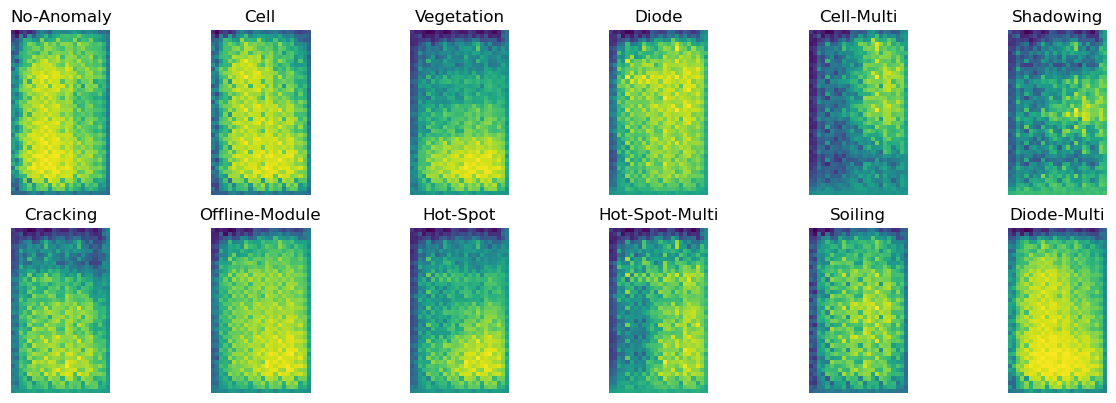

[Epoch 1/500] [D loss: 0.6894018132487932] [G loss: 0.7088469357291858]
[Epoch 2/500] [D loss: 0.688039827744166] [G loss: 0.7192386184136073]
[Epoch 3/500] [D loss: 0.6901565473278364] [G loss: 0.711261603931586]
[Epoch 4/500] [D loss: 0.6887121274073918] [G loss: 0.7102917100985845]
[Epoch 5/500] [D loss: 0.6876955187320709] [G loss: 0.718414322535197]
[Epoch 6/500] [D loss: 0.6892853440841039] [G loss: 0.7162324952085813]
[Epoch 7/500] [D loss: 0.6892514435450235] [G loss: 0.7114690968394279]
[Epoch 8/500] [D loss: 0.6890393056472143] [G loss: 0.7135233387351037]
[Epoch 9/500] [D loss: 0.687969122727712] [G loss: 0.7156633150577545]
[Epoch 10/500] [D loss: 0.688050168355306] [G loss: 0.7169024083018303]


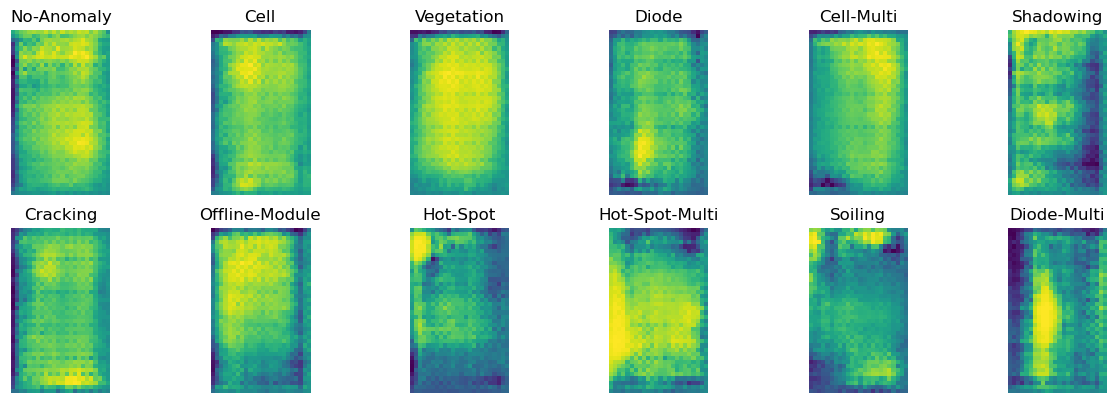

[Epoch 11/500] [D loss: 0.686810989578565] [G loss: 0.7216272093852361]
[Epoch 12/500] [D loss: 0.6852283098300298] [G loss: 0.724353558520476]
[Epoch 13/500] [D loss: 0.684084923962752] [G loss: 0.7301407299439112]
[Epoch 14/500] [D loss: 0.6824493058522543] [G loss: 0.7342312887310982]
[Epoch 15/500] [D loss: 0.6804289123415947] [G loss: 0.7418505049745242]
[Epoch 16/500] [D loss: 0.6784652202328046] [G loss: 0.7419461776812871]
[Epoch 17/500] [D loss: 0.6758548892537752] [G loss: 0.7520595602194469]
[Epoch 18/500] [D loss: 0.6724548250436783] [G loss: 0.7599542339642843]
[Epoch 19/500] [D loss: 0.6700414628783862] [G loss: 0.7678462807337443]
[Epoch 20/500] [D loss: 0.666621954937776] [G loss: 0.7755891608198484]


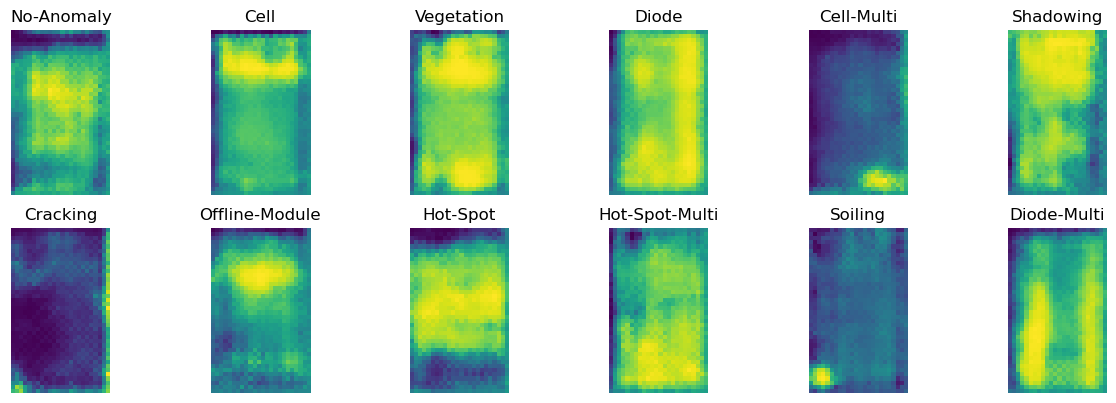

[Epoch 21/500] [D loss: 0.6637565465768178] [G loss: 0.7849100083112717]
[Epoch 22/500] [D loss: 0.6592136277755102] [G loss: 0.7947852971156438]
[Epoch 23/500] [D loss: 0.655773368080457] [G loss: 0.8040061145027478]
[Epoch 24/500] [D loss: 0.6514168730378151] [G loss: 0.8198337348302206]
[Epoch 25/500] [D loss: 0.647901076277097] [G loss: 0.8289058622717858]
[Epoch 26/500] [D loss: 0.6435847156246504] [G loss: 0.8392023197809855]
[Epoch 27/500] [D loss: 0.6395767363905906] [G loss: 0.8500775296489398]
[Epoch 28/500] [D loss: 0.6351368448138237] [G loss: 0.8638010935982069]
[Epoch 29/500] [D loss: 0.630719505250454] [G loss: 0.8804243373870849]
[Epoch 30/500] [D loss: 0.6261066803336144] [G loss: 0.8942122323314349]


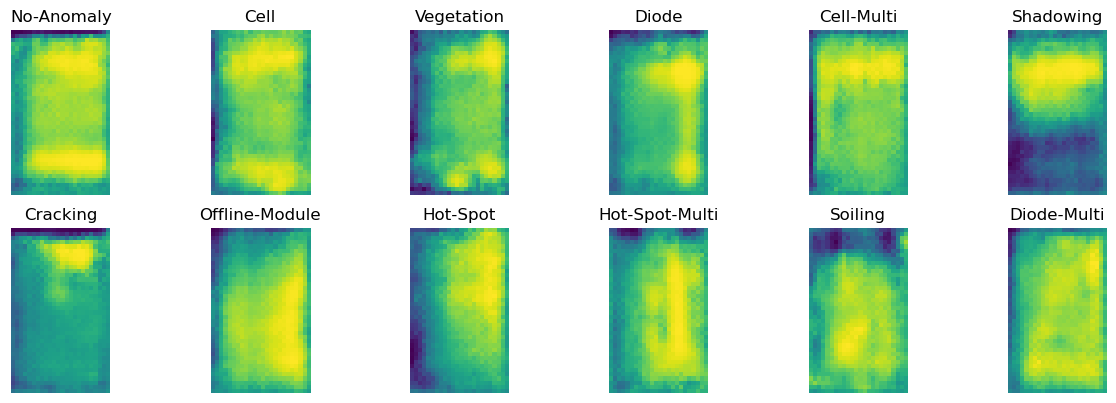

[Epoch 31/500] [D loss: 0.6224124172329902] [G loss: 0.9075621140003204]
[Epoch 32/500] [D loss: 0.6174052912990252] [G loss: 0.9193803512056669]
[Epoch 33/500] [D loss: 0.6144339272379875] [G loss: 0.9361050089200338]
[Epoch 34/500] [D loss: 0.6084338329235712] [G loss: 0.9524672387043635]
[Epoch 35/500] [D loss: 0.6043920343120893] [G loss: 0.9680895714958508]
[Epoch 36/500] [D loss: 0.600087026556333] [G loss: 0.9806179450949033]
[Epoch 37/500] [D loss: 0.597191879649957] [G loss: 0.9937762413422266]
[Epoch 38/500] [D loss: 0.5940240085124969] [G loss: 1.00712350577116]
[Epoch 39/500] [D loss: 0.5881958947579066] [G loss: 1.0254917429884274]
[Epoch 40/500] [D loss: 0.5852341590325038] [G loss: 1.040899671713511]


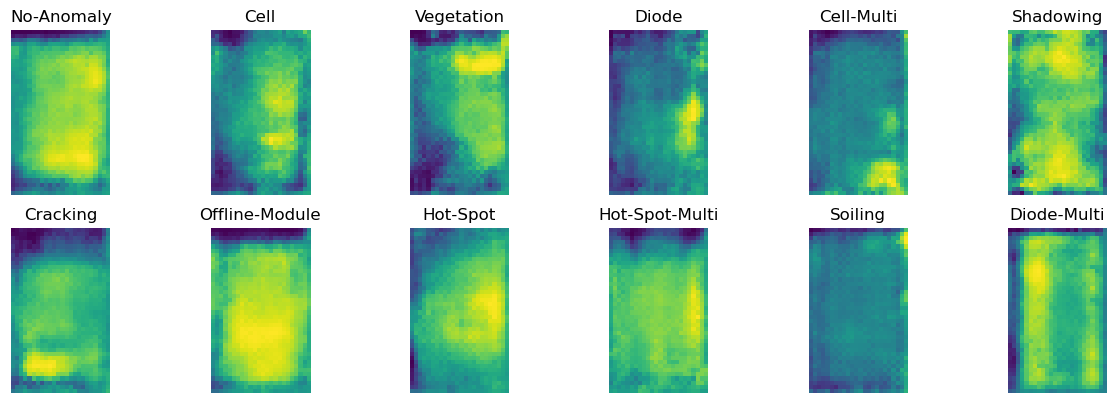

[Epoch 41/500] [D loss: 0.5810291443268458] [G loss: 1.053219282925129]
[Epoch 42/500] [D loss: 0.5783334386348724] [G loss: 1.0669585984945298]
[Epoch 43/500] [D loss: 0.5754842949906985] [G loss: 1.0837865631779036]
[Epoch 44/500] [D loss: 0.5715170658628146] [G loss: 1.0968275207281113]
[Epoch 45/500] [D loss: 0.5681588342785835] [G loss: 1.1113833713531494]
[Epoch 46/500] [D loss: 0.5647959780693054] [G loss: 1.1250678247213364]
[Epoch 47/500] [D loss: 0.562165697813034] [G loss: 1.1327995241681734]
[Epoch 48/500] [D loss: 0.5586976076662541] [G loss: 1.1496825258930523]
[Epoch 49/500] [D loss: 0.5538816502690316] [G loss: 1.1665228871504465]
[Epoch 50/500] [D loss: 0.5514737371603647] [G loss: 1.1855654331048329]


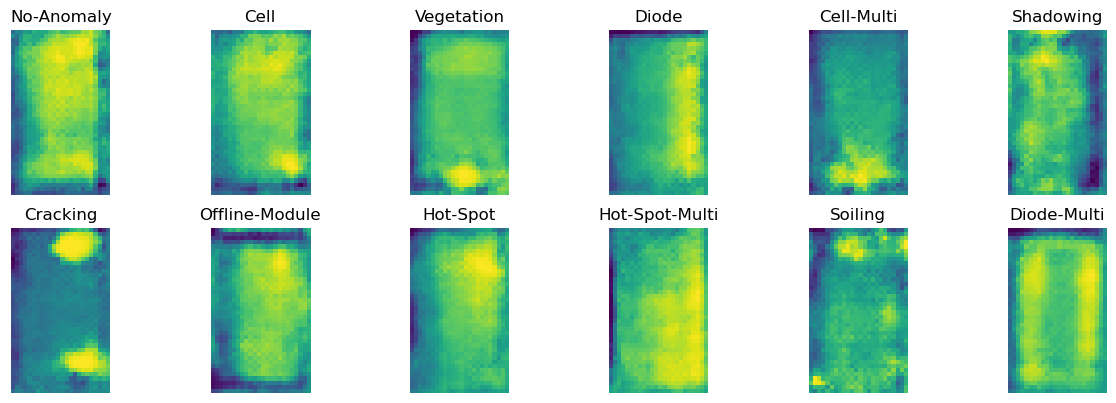

[Epoch 51/500] [D loss: 0.5483247223496437] [G loss: 1.1965450675288836]
[Epoch 52/500] [D loss: 0.5459458469847838] [G loss: 1.2086247825622558]
[Epoch 53/500] [D loss: 0.5429962516327699] [G loss: 1.217776805361112]
[Epoch 54/500] [D loss: 0.5389832090338071] [G loss: 1.2363968058427175]
[Epoch 55/500] [D loss: 0.5375888773798942] [G loss: 1.251545871992906]
[Epoch 56/500] [D loss: 0.5341718851029873] [G loss: 1.2668756411472957]


In [179]:
fit_total_loss_gen, fit_total_loss_disc = g_model.fit(g_train_test.train_dataloader, epochs=500)

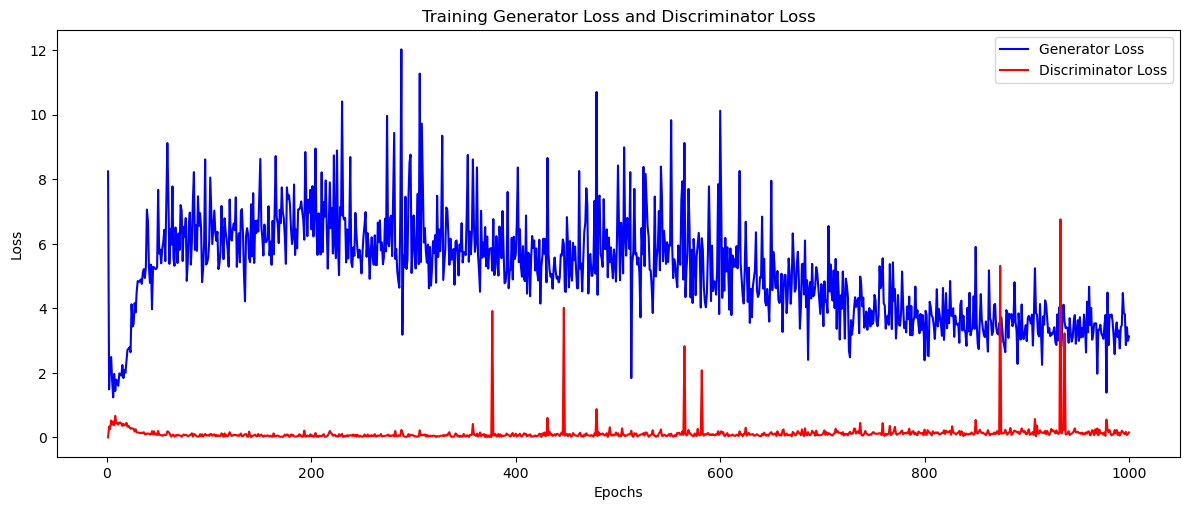

In [29]:
# Plot the loss and accuracy curves
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

axs.plot(range(1, len(fit_total_loss_gen) + 1), fit_total_loss_gen, color='b', label="Generator Loss")
axs.plot(range(1, len(fit_total_loss_disc) + 1), fit_total_loss_disc, color='r', label="Discriminator Loss")
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()

plt.tight_layout()  # ensure the two axes are on the same scale
plt.title('Training Generator Loss and Discriminator Loss')
plt.show()

In [155]:
def preprocess_gan_agument(image, aug_number, label):
    image_list = []
    if aug_number == 0:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = (image - 127.5) / 127.5
        image = image[np.newaxis]
        image_list.append(image)
    else:
        for _ in range(aug_number):
            img_aug = g_model.augment(1, solar_dataset.classes_list.index(label))
            for im in img_aug:
                image_list.append(im.cpu().numpy())
    return image_list

In [166]:
class GanClassificator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_dim[0], 60, 3, 1, 1),
            #nn.BatchNorm2d(60),
            nn.ReLU(),
            #nn.Dropout(0.50),
            nn.MaxPool2d(2, 2),
            # Input is Zx20x12
            nn.Conv2d(60, 120, 3, 1, 1),
            #nn.BatchNorm2d(120),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.MaxPool2d(2, 2),
            # Input is Zx10x6
            nn.Conv2d(120, 240, 3, 1, 1),
            #nn.BatchNorm2d(240),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.MaxPool2d(2, 2),
            # Input is Zx5x3
            nn.Conv2d(240, 480, (5, 3), 1, 0),
            #nn.BatchNorm2d(480),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Flatten(),
            nn.Linear(480, 960),
            nn.Sigmoid(),
            nn.Linear(960, out_dim),
        )

    def forward(self, x):
        return self.model(x)

In [169]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model = GanClassificator(input_dim, output_dim).to(device)
print(summary(our_model, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss = nn.CrossEntropyLoss().to(device)
our_optimizer = Adam(our_model.parameters(), lr=0.0003)
our_train_test = utils.TrainTest(
    our_model,
    our_loss,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_gan_agument,
    augment=True,
)

Layer (type:depth-idx)                   Output Shape              Param #
GanClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 60, 40, 24]           600
│    └─BatchNorm2d: 2-2                  [1, 60, 40, 24]           120
│    └─ReLU: 2-3                         [1, 60, 40, 24]           --
│    └─Dropout: 2-4                      [1, 60, 40, 24]           --
│    └─MaxPool2d: 2-5                    [1, 60, 20, 12]           --
│    └─Conv2d: 2-6                       [1, 120, 20, 12]          64,920
│    └─ReLU: 2-7                         [1, 120, 20, 12]          --
│    └─Dropout: 2-8                      [1, 120, 20, 12]          --
│    └─MaxPool2d: 2-9                    [1, 120, 10, 6]           --
│    └─Conv2d: 2-10                      [1, 240, 10, 6]           259,440
│    └─ReLU: 2-11                        [1, 240, 10, 6]           --
│   

Loss = 1.1305335831074488   Accuracy= 0.6468253968253969
Best Epoch # 0  Validation Loss= 1.1305335831074488  Validation Accu= 0.6468253968253969
Loss = 0.9815921896979922   Accuracy= 0.6959325396825397
Best Epoch # 1  Validation Loss= 0.9815921896979922  Validation Accu= 0.6959325396825397
Loss = 0.9237130170776731   Accuracy= 0.7023809523809523
Best Epoch # 2  Validation Loss= 0.9237130170776731  Validation Accu= 0.7023809523809523
Loss = 0.8719361315643976   Accuracy= 0.7142857142857143
Best Epoch # 3  Validation Loss= 0.8719361315643976  Validation Accu= 0.7142857142857143
Loss = 0.8309437256483805   Accuracy= 0.7242063492063492
Best Epoch # 4  Validation Loss= 0.8309437256483805  Validation Accu= 0.7242063492063492
Loss = 0.8078834584781102   Accuracy= 0.7321428571428571
Best Epoch # 5  Validation Loss= 0.8078834584781102  Validation Accu= 0.7321428571428571
Loss = 0.787713940536219   Accuracy= 0.7418154761904762
Best Epoch # 6  Validation Loss= 0.787713940536219  Validation Accu=

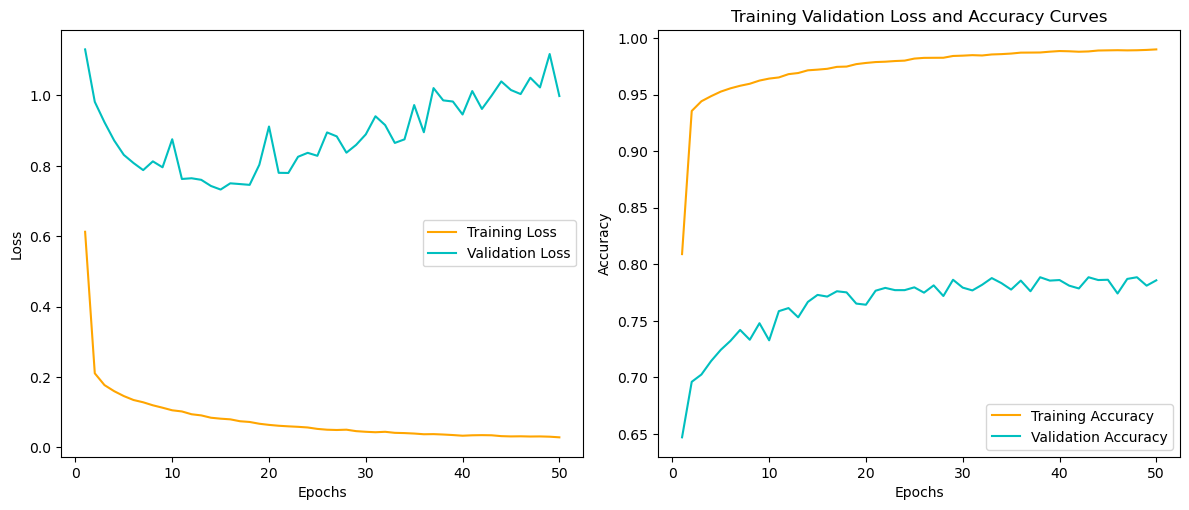

In [170]:
# Train Model
our_best_gan_loss, our_best_gan_accuracy, our_best_gan_epoch = our_train_test.train(our_optimizer, 50, "our_model_gan.pth")

Loss = 1.3860246645926964   Accuracy= 0.78125


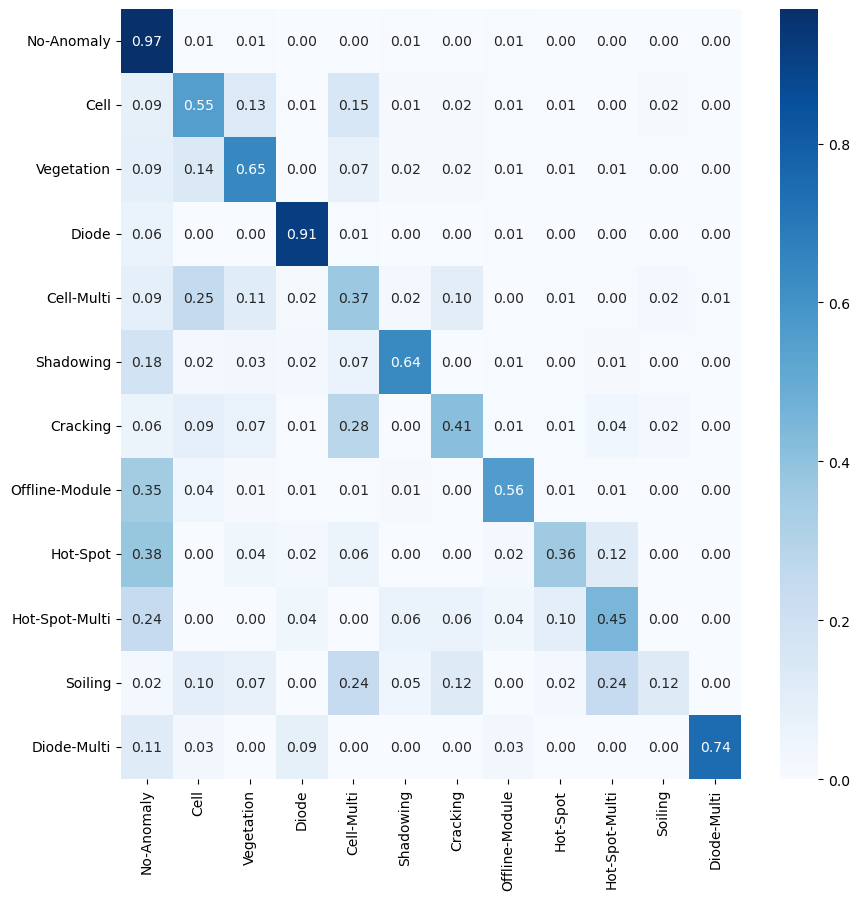

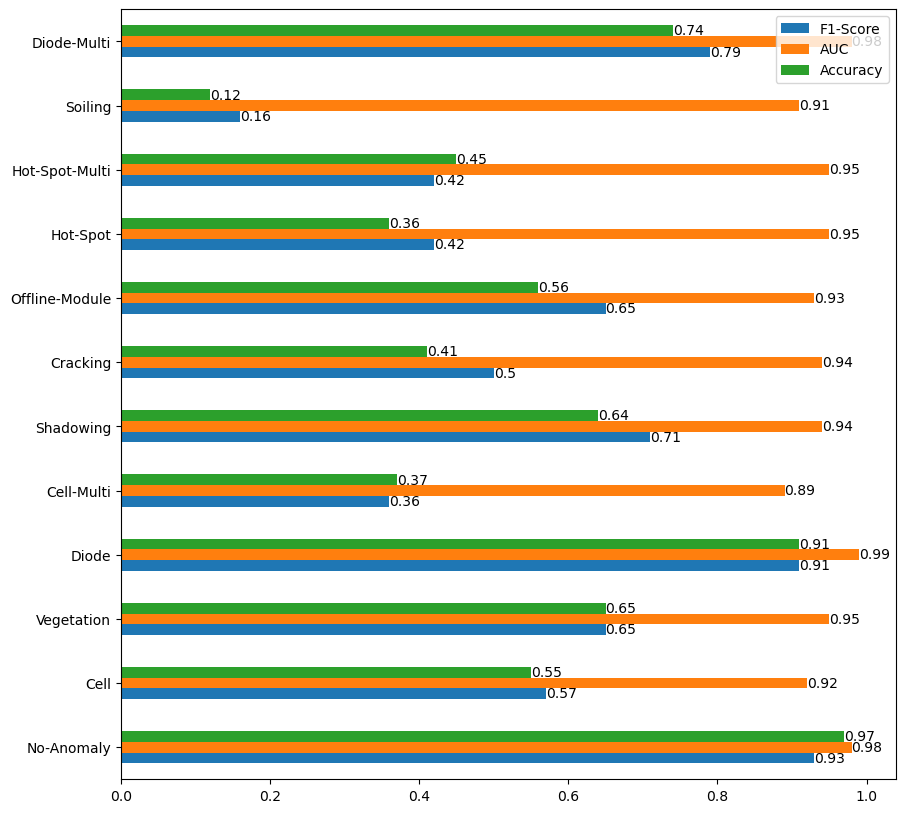

In [164]:
our_train_test.test()
our_train_test.plot_confusion_matrix()
our_train_test.plot_class_metrics()

---

# Pre-Trained Models

In computer vision, transfer learning is commonly used with convolutional neural networks (CNNs) pre-trained on large image datasets like ImageNet. These pre-trained models can be used as a fixed feature extractor for tasks such as object detection, image segmentation, and image classification.

After running our models we decided to use pre trained models:


*   Resnet18
*   Visual Transformers
<br><br>

The use of pre trained models in deep learning has some advantages such as:

**Reducing the training time** - since this models are already trained on large and diverse datasets like ImageNet they've learned rich feature representations.

**Less Labeled Data Required** -  they can perform well with smaller amounts of labeled data for the target task. This is crucial in scenarios where collecting large labeled datasets is time-consuming or expensive.

**Resource Savings**: Training deep neural networks from scratch requires significant computational resources. By using pre-trained models, we can save time, computing power, and energy consumption.

**Feature Retention through Freezing**: One of the key steps in transfer learning is the ability to freeze the layers of the pre-trained model so that only some portions of the network are updated during training. Freezing is crucial to maintain the features that the pre-trained model has already learned.

<br><br>

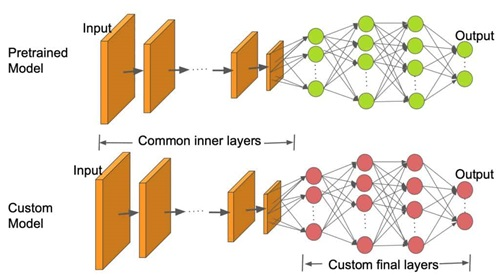

<br><br>

The image above ilustrates well one of the keys points for using pre-trained models in this project. The possibility of changeing the existing archisture of the model - we can freeze most of the parameters and use/change the others. Unfreezing a layer means that the weights and biases of that layer will be updated during the training process.



# Pretrained ResNET 18

ResNet18 is a relatively lightweight convolutional neural network (CNN) compared to deeper architectures like ResNet50 or ResNet101. For tasks with limited computational resources or not extremely complex this model offers a good balance between complexity and performance. Due to its smallers size, compared with the other models, it requires less time to train facilitating easy experimentation with different architectures or hyperparameters within a reasonable time frame. It is also resource efficient in terms of memory and computation.
<br><br>
For this task we start to freeze all the parameters.
Then we unfreeze the last layer and change the number of classes in the output, the default was 10 and we increase it to 12 (our dataset classes).
Unfreezing the last layer means allowing the weights and biases of that specific layer to be updated during the training process, improve the model performance and adapting it to new labels.
The learning rate for the optimizer was also updated, while the rest of the model is running with a learning rate of 0.0001, the fourth layer is 0.001.


In [30]:
torch.cuda.empty_cache()

In [25]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 11           |        cudaMalloc retries: 11        |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  26775 MiB |  26796 MiB | 241250 MiB | 214475 MiB |\n|       from large pool |  26731 MiB |  26750 MiB | 240180 MiB | 213449 MiB |\n|       from small pool |     44 MiB |     47 MiB |   1069 MiB |   1025 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  26775 MiB |  26796 MiB | 241250 MiB | 214475 MiB |\n|       from large pool |  26731 MiB |  26750 MiB |

In [9]:
import os

# Set PYTORCH_CUDA_ALLOC_CONF environment variable
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = ""

In [24]:
def preprocess_resnet(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.21),
            #transforms.ToTensor(),
            #transforms.Normalize(mean=(0.5652, 0.5652, 0.5652), std=(0.5, 0.5, 0.5)),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            #transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

## MobileNetV2

In [15]:
def preprocess_mobile(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.21),
            #transforms.ToTensor(),
            #transforms.Normalize(mean=(0.5652, 0.5652, 0.5652), std=(0.5, 0.5, 0.5)),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            #transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [20]:
input_dim = (3, 40, 24)

model_mobile = torchvision.models.mobilenet_v2(pretrained=True)
for i, param in enumerate(model_mobile.parameters()):
    param.requires_grad = False
    if i >= 150:
        break

num_features = model_mobile.classifier[1].in_features
model_mobile.classifier[1] = nn.Sequential(
    nn.Linear(num_features, 640),
    nn.ReLU(),
    nn.Linear(640, 12), 
)

print(summary(model_mobile.to(device), (1, input_dim[0], input_dim[1], input_dim[2])))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 12]                   --
├─Sequential: 1-1                                  [1, 1280, 2, 1]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 20, 12]           --
│    │    └─Conv2d: 3-1                            [1, 32, 20, 12]           (864)
│    │    └─BatchNorm2d: 3-2                       [1, 32, 20, 12]           (64)
│    │    └─ReLU6: 3-3                             [1, 32, 20, 12]           --
│    └─InvertedResidual: 2-2                       [1, 16, 20, 12]           --
│    │    └─Sequential: 3-4                        [1, 16, 20, 12]           (896)
│    └─InvertedResidual: 2-3                       [1, 24, 10, 6]            --
│    │    └─Sequential: 3-5                        [1, 24, 10, 6]            (5,136)
│    └─InvertedResidual: 2-4                       [1, 24, 10, 6]            --
│    │    └─Sequential

In [21]:
loss_mobile = nn.BCEWithLogitsLoss().to(device)
optimizer_mobile = torch.optim.AdamW(model_mobile.parameters(), lr=0.00025, weight_decay=0.01)
train_test_mobile = utils.TrainTest(
    model_mobile.to(device),
    loss_mobile,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_mobile,
    augment=False,
)

Loss = 0.18139966994524   Accuracy= 0.56225
Best Epoch # 0  Validation Loss= 0.18139966994524  Validation Accu= 0.56225
Loss = 0.17379556864500045   Accuracy= 0.5815
Best Epoch # 1  Validation Loss= 0.17379556864500045  Validation Accu= 0.5815
Loss = 0.16769974690675735   Accuracy= 0.60075
Best Epoch # 2  Validation Loss= 0.16769974690675735  Validation Accu= 0.60075
Loss = 0.16947895628213883   Accuracy= 0.5965
Loss = 0.16414558804035187   Accuracy= 0.604
Best Epoch # 4  Validation Loss= 0.16414558804035187  Validation Accu= 0.604
Loss = 0.16358537918329238   Accuracy= 0.60875
Best Epoch # 5  Validation Loss= 0.16358537918329238  Validation Accu= 0.60875
Loss = 0.16278171142935752   Accuracy= 0.6095
Best Epoch # 6  Validation Loss= 0.16278171142935752  Validation Accu= 0.6095
Loss = 0.1614207810163498   Accuracy= 0.6185
Best Epoch # 7  Validation Loss= 0.1614207810163498  Validation Accu= 0.6185
Loss = 0.1600459627509117   Accuracy= 0.619
Best Epoch # 8  Validation Loss= 0.16004596275

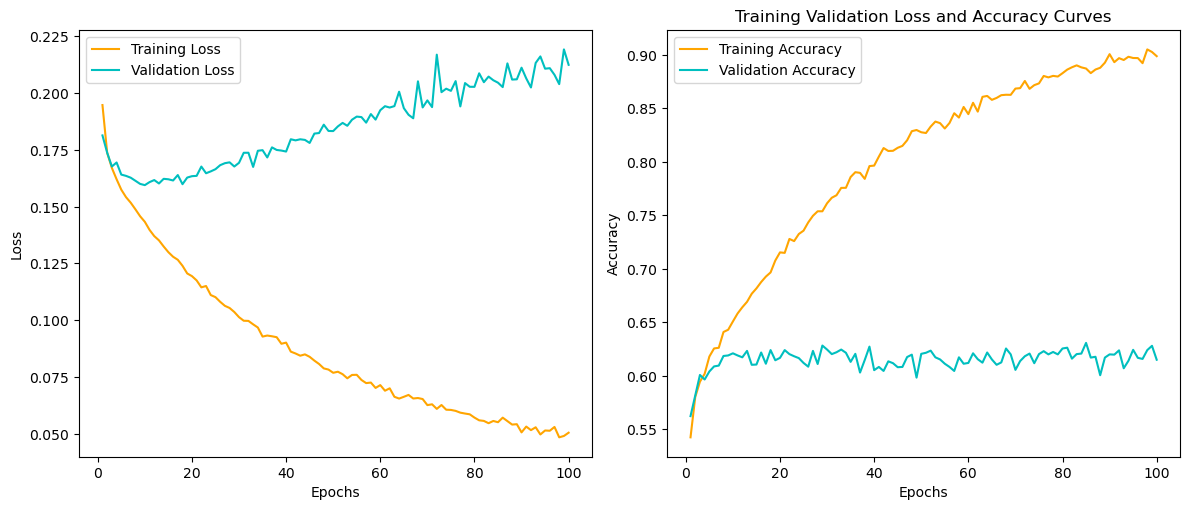

In [22]:
# Train Model
our_best_mobile_loss, our_best_mobile_accuracy, our_best_mobile_epoch = train_test_mobile.train(optimizer_mobile, 100, "mobile_model.pth")

Loss = 0.21248448100686074   Accuracy= 0.615


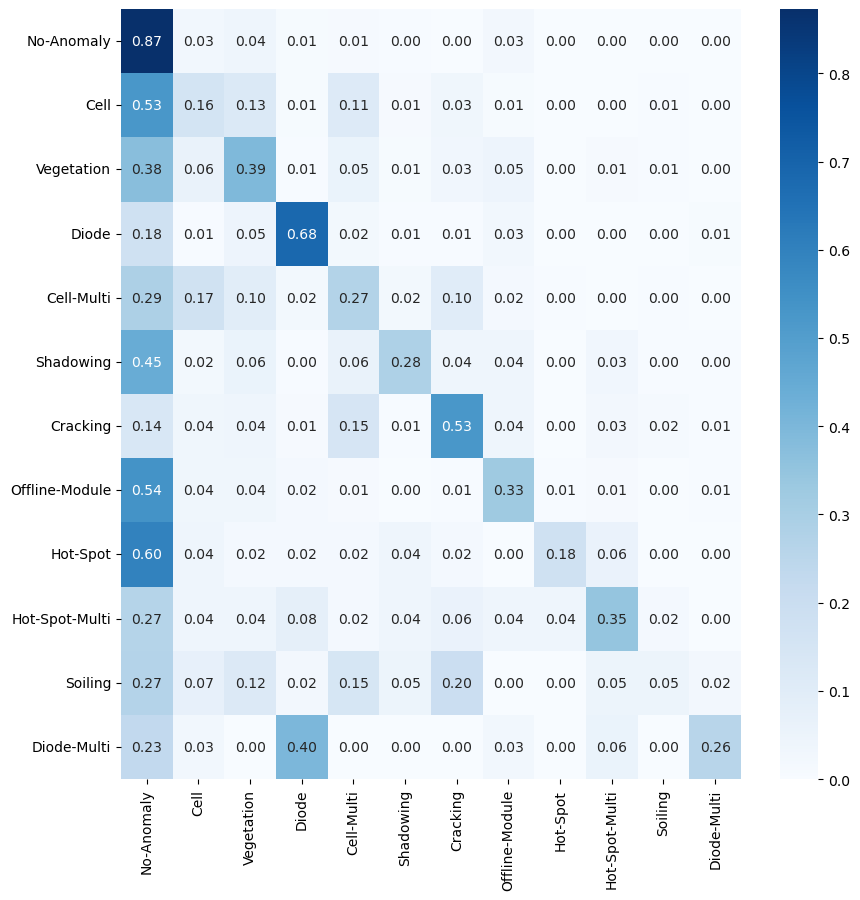

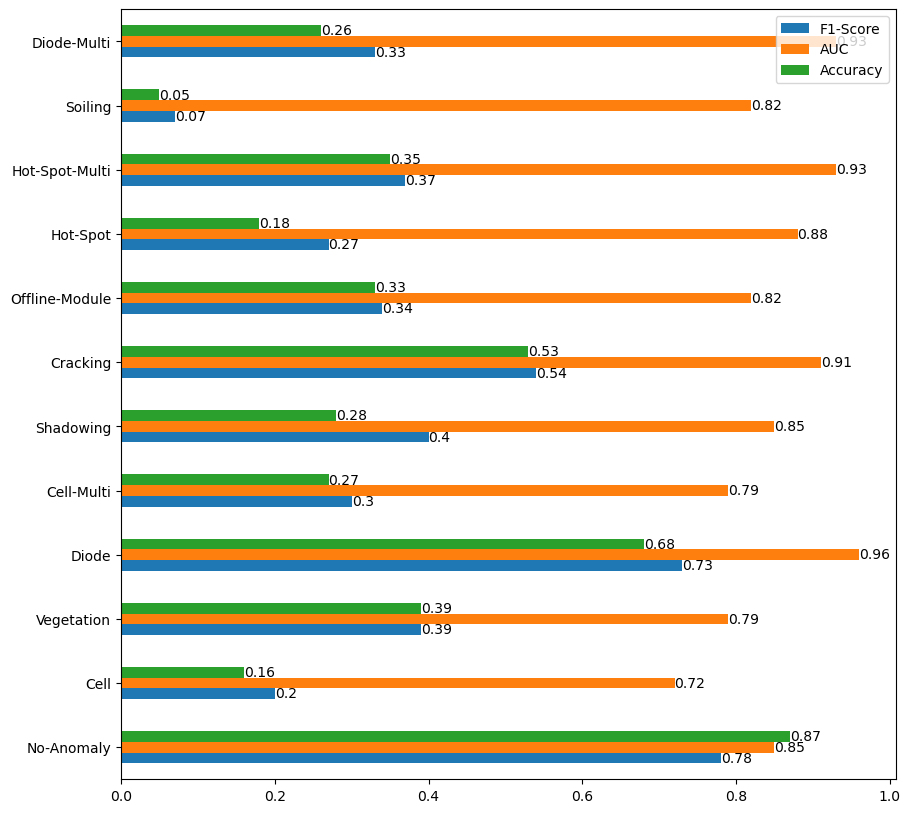

In [23]:
train_test_mobile.test()
train_test_mobile.plot_confusion_matrix()
train_test_mobile.plot_class_metrics()

## Resnet 18

In [117]:
input_dim = (3, 40, 24)
model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=torchvision.models.ResNet18_Weights.DEFAULT)

# Replace last layer
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 12),
    #nn.ReLU(),
    #nn.Dropout(0.60),
    #nn.Linear(480, 12),
    #nn.Sigmoid(),
    #nn.Linear(960, 12),        
)
model_resnet.layer1.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))
model_resnet.layer2.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))
model_resnet.layer3.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))
model_resnet.layer4.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))
#model_resnet.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.7, training=m.training))

#for p in model_resnet.parameters():
#    p.requires_grad = False
#for p in model_resnet.fc.parameters():
#    p.requires_grad = True
#for p in model_resnet.layer3.parameters():
#    p.requires_grad = True
#for p in model_resnet.layer4.parameters():
#    p.requires_grad = True

print(summary(model_resnet.to(device), (1, input_dim[0], input_dim[1], input_dim[2])))

Using cache found in C:\Users\catia/.cache\torch\hub\pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 12]                   --
├─Conv2d: 1-1                            [1, 64, 20, 12]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 20, 12]           128
├─ReLU: 1-3                              [1, 64, 20, 12]           --
├─MaxPool2d: 1-4                         [1, 64, 10, 6]            --
├─Sequential: 1-5                        [1, 64, 10, 6]            --
│    └─BasicBlock: 2-1                   [1, 64, 10, 6]            --
│    │    └─Conv2d: 3-1                  [1, 64, 10, 6]            36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 10, 6]            128
│    │    └─ReLU: 3-3                    [1, 64, 10, 6]            --
│    │    └─Conv2d: 3-4                  [1, 64, 10, 6]            36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 10, 6]            128
│    │    └─ReLU: 3-6                    [1, 64, 10, 6]            --
│

In [115]:
#Changing the learning rate
loss_resnet = nn.BCEWithLogitsLoss().to(device)
#optimizer_resnet = SGD([
#    {'params': model_resnet.layer3.parameters(), 'lr': 0.001},
#    # {'params': model_resnet.layer4.parameters(), 'lr': 0.001},
#    {'params': model_resnet.fc.parameters(), 'lr': 0.0001},
#], momentum=0.9)
#optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=0.0000325)
optimizer_resnet = torch.optim.AdamW(model_resnet.parameters(), lr=0.000125, weight_decay=0.01)
train_test_resnet = utils.TrainTest(
    model_resnet.to(device),
    loss_resnet,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_resnet,
    augment=False,
)

In [116]:
# Train Model
our_best_resnet_loss, our_best_resnet_accuracy, our_best_resnet_epoch = train_test_resnet.train(optimizer_resnet, 50, "resnet158_model.pth")

Loss = 0.17261692702770234   Accuracy= 0.61
Best Epoch # 0  Validation Loss= 0.17261692702770234  Validation Accu= 0.61
Loss = 0.14705175417661667   Accuracy= 0.651
Best Epoch # 1  Validation Loss= 0.14705175417661667  Validation Accu= 0.651
Loss = 0.14428383342921733   Accuracy= 0.6435
Loss = 0.1423670002222061   Accuracy= 0.65025
Loss = 0.12957852679491044   Accuracy= 0.68675
Best Epoch # 4  Validation Loss= 0.12957852679491044  Validation Accu= 0.68675
Loss = 0.1309065513163805   Accuracy= 0.69375
Best Epoch # 5  Validation Loss= 0.1309065513163805  Validation Accu= 0.69375
Loss = 0.1429342241436243   Accuracy= 0.69
Loss = 0.1425778181552887   Accuracy= 0.665
Loss = 0.1481802465841174   Accuracy= 0.6845
Loss = 0.15207803709805012   Accuracy= 0.68675
Loss = 0.16749366781115532   Accuracy= 0.68875
Loss = 0.18582663879916073   Accuracy= 0.67075
Loss = 0.1881521973013878   Accuracy= 0.68825
Loss = 0.2052638845872134   Accuracy= 0.68425
Loss = 0.19449223217368125   Accuracy= 0.6905
Loss 

KeyboardInterrupt: 

Loss = 0.17666659849882127   Accuracy= 0.68025


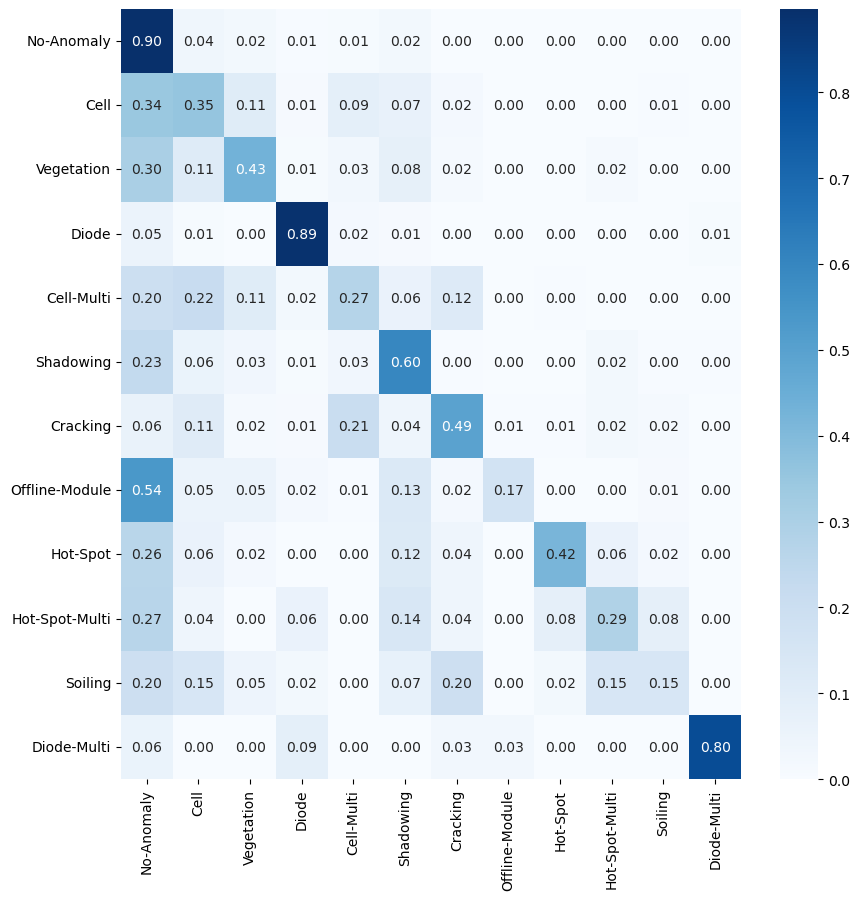

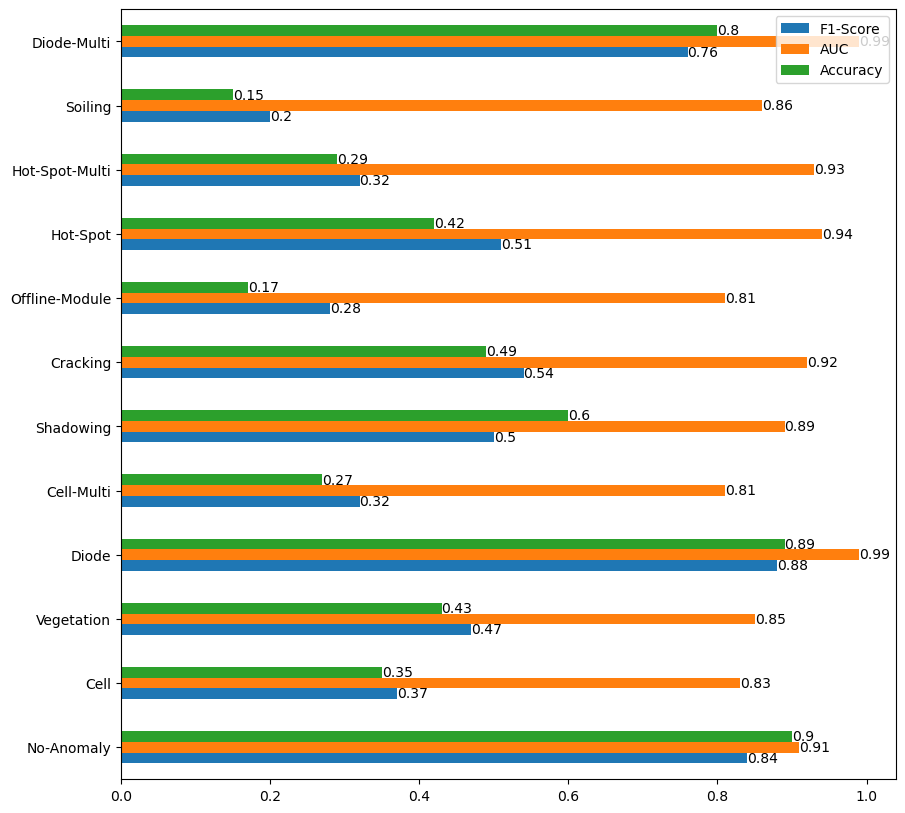

In [110]:
train_test_resnet.test()
train_test_resnet.plot_confusion_matrix()
train_test_resnet.plot_class_metrics()

# Pretrained Transformer

In [16]:
def preprocess_vit(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.21),
            #transforms.ToTensor(),
            #transforms.Normalize(mean=(0.5652, 0.5652, 0.5652), std=(0.5, 0.5, 0.5)),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [29]:
input_dim = (3, 224, 224)
weights_vit = torchvision.models.ViT_B_16_Weights.DEFAULT
model_vit = torchvision.models.vit_b_16(weights=weights_vit)
for p in model_vit.parameters():
    p.requires_grad = False

heads_vit = nn.Sequential(nn.Linear(in_features=768, out_features=12, bias=True))
model_vit.heads = heads_vit

summary(model_vit, input_size=(1, input_dim[0], input_dim[1], input_dim[2]))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 12]                   768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [30]:
loss_vit = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_vit.parameters()),
    lr=0.0001)
train_test_vit = utils.TrainTest(
    model_vit,
    loss_vit,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_vit,
    augment=False,
)

In [31]:
# Train Model
our_best_vit_loss, our_best_vit_accuracy, our_best_vit_epoch = train_test_vit.train(optimizer_vit, 10, "resnet_model_vit.pth")

KeyboardInterrupt: 

# Results and discussion

TBD

# Conclusions

TBD

# References

https://www.sciencedirect.com/science/article/pii/S0263224123006991?via%3Dihub

https://openaccess.thecvf.com/content/CVPR2021/papers/Li_On_Feature_Normalization_and_Data_Augmentation_CVPR_2021_paper.pdf

https://arxiv.org/abs/2103.15158

https://arxiv.org/pdf/2010.11929.

https://www.frontiersin.org/articles/10.3389/fdata.2021.659146/full

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8253599

https://www.sciencedirect.com/science/article/abs/pii/S0957417417306346

https://www.foldl.me/uploads/2015/conditional-gans-face-generation/paper.pdf